# Publication-Quality Bayesian Optimization for Cu₃VS₄ Nanoparticle Synthesis

This notebook implements a **theoretically rigorous** constrained Bayesian optimization framework for targeted nanoparticle synthesis.

## Key Improvements Over Standard Implementations

| Feature | Standard | This Implementation |
|---------|----------|--------------------|
| Acquisition Function | Arbitrary LCB/UCB | Expected Improvement (EI) with feasibility weighting |
| Kernel | RBF | Matérn 5/2 (standard in materials science) |
| Sampling | Pure random | Latin Hypercube (space-filling) |
| Validation | Train R² only | LOO-CV with RMSE, MAE, calibration |
| Uncertainty | Not checked | Full calibration analysis |
| Figures | Basic plots | Publication-quality with proper formatting |

## References
- Jones et al. (1998) - Efficient Global Optimization
- Gelbart et al. (2014) - Bayesian Optimization with Unknown Constraints
- Rasmussen & Williams (2006) - Gaussian Processes for Machine Learning

---

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import os
import warnings

# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel as C, WhiteKernel
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, roc_auc_score, brier_score_loss
from sklearn.ensemble import RandomForestClassifier

# Statistical imports
from scipy.stats import norm, spearmanr
from scipy.spatial.distance import cdist
from scipy.stats.qmc import LatinHypercube

# Persistence
import joblib
from datetime import datetime
import uuid

warnings.filterwarnings('ignore')

print("Imports successful!")

Imports successful!


In [2]:
# =============================================================================
# PUBLICATION-QUALITY PLOT SETTINGS
# =============================================================================
def set_publication_style():
    """Set matplotlib parameters for publication-quality figures."""
    plt.rcParams.update({
        'figure.dpi': 150,
        'savefig.dpi': 300,
        'font.size': 10,
        'axes.titlesize': 11,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'figure.figsize': (4, 3.5),
        'axes.linewidth': 0.8,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'font.family': 'sans-serif',
    })

set_publication_style()

# Consistent color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'tertiary': '#F18F01',
    'success': '#2E8B57',
    'warning': '#E63946',
    'neutral': '#6C757D',
}

## 1. Data Loading & Configuration

**Edit `DATA_PATH` to point to your dataset.**

In [3]:
# =============================================================================
# DATA PATH - EDIT THIS
# =============================================================================
DATA_PATH = r"/Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Data/COMPLETE_CUVS_DATA_PDI.csv"

# =============================================================================
# CONFIGURATION
# =============================================================================
FACTOR_ORDER = ["Temp", "Time", "VOacac", "DDT", "OAm"]
OBJECTIVES = ["Size", "PDI", "Squareness"]
FEAS_COLS = ["HasProduct", "PhasePure"]

# Polymorph handling
POLYMORPH_COL = "Polymorph"
CUBIC_LABEL = "cubic"

# Parameter bounds (synthesis constraints)
BOUNDS = {
    "Temp":   (260.0, 310.0),   # °C
    "Time":   (8.0, 90.0),      # minutes
    "VOacac": (0.08, 0.66),     # mmol
    "DDT":    (1.0, 5.0),       # mL
    "OAm":    (1.0, 7.0),       # mL
}

# Objective weights (higher = more important)
OBJECTIVE_WEIGHTS = {
    "PDI": 1.5,        # Minimizing size distribution
    "Squareness": 0.5  # Maximizing morphology quality
}

In [4]:
# =============================================================================
# LOAD AND PREPARE DATA
# =============================================================================
@dataclass
class Constraint:
    """Bounds for a synthesis parameter."""
    min_val: float
    max_val: float

def load_and_prepare_data(path: str) -> pd.DataFrame:
    """Load and validate the dataset."""
    # Load
    if path.endswith('.csv'):
        df = pd.read_csv(path)
    elif path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported format: {path}")
    
    df.columns = [c.strip() for c in df.columns]
    
    # Validate required columns
    required = FACTOR_ORDER + OBJECTIVES + FEAS_COLS
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    
    # Coerce to numeric
    for c in FACTOR_ORDER + OBJECTIVES:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    
    # Binary feasibility
    for c in FEAS_COLS:
        df[c] = df[c].astype(bool).astype(int)
    
    # IsCubic from Polymorph
    if POLYMORPH_COL in df.columns:
        df["IsCubic"] = (
            df[POLYMORPH_COL].astype(str).str.lower().str.strip() == CUBIC_LABEL.lower()
        ).astype(int)
    else:
        df["IsCubic"] = 1
    
    # Drop rows missing factors
    df = df.dropna(subset=FACTOR_ORDER).reset_index(drop=True)
    
    return df

# Load data
df = load_and_prepare_data(DATA_PATH)

# Convert bounds to Constraint objects
bounds = {k: Constraint(v[0], v[1]) for k, v in BOUNDS.items()}

print(f"Dataset loaded: {len(df)} total experiments")
print(f"Successful (HasProduct=1): {df['HasProduct'].sum()}")
print(f"Phase Pure: {df['PhasePure'].sum()}")
print(f"Cubic: {df['IsCubic'].sum()}")
display(df.head())

Dataset loaded: 41 total experiments
Successful (HasProduct=1): 31
Phase Pure: 17
Cubic: 27


,Temp,Time,VOacac,DDT,OAm,Run_ID,PDI,Squareness,Size,PhasePure,HasProduct,Polymorph,IsCubic
0,260,8,0.08,1.0,7.0,1,NaN,NaN,NaN,0,0,NaN,0
1,260,8,0.08,5.0,1.0,2,NaN,NaN,NaN,0,0,NaN,0
2,260,8,0.66,1.0,1.0,3,NaN,NaN,NaN,0,0,NaN,0
3,260,8,0.66,5.0,7.0,4,NaN,NaN,NaN,0,0,NaN,0
4,260,90,0.08,1.0,1.0,5,0.330018,0.502,11.241,0,1,cubic,1


In [5]:
# =============================================================================
# DATA SUMMARY
# =============================================================================
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)

# Factors
print("\nSynthesis Parameters (Factors):")
print(df[FACTOR_ORDER].describe().round(2))

# Objectives (successful only)
df_success = df[df["HasProduct"] == 1]
print(f"\nObjective Properties (n={len(df_success)} successful):")
print(df_success[OBJECTIVES].describe().round(3))

# Feasibility distribution
print("\nFeasibility Distribution:")
for col in ["HasProduct", "PhasePure", "IsCubic"]:
    counts = df[col].value_counts()
    print(f"  {col}: {counts.get(1, 0)} success / {counts.get(0, 0)} fail")


DATASET SUMMARY

Synthesis Parameters (Factors):
         Temp   Time  VOacac    DDT    OAm
count   41.00  41.00   41.00  41.00  41.00
mean   285.59  49.95    0.36   2.86   3.93
std     21.40  35.03    0.25   1.69   2.56
min    260.00   8.00    0.08   1.00   1.00
25%    260.00   8.00    0.08   1.00   1.00
50%    285.00  49.00    0.37   3.00   4.00
75%    310.00  90.00    0.66   5.00   7.00
max    310.00  90.00    0.66   5.00   7.00

Objective Properties (n=31 successful):
         Size     PDI  Squareness
count  31.000  31.000      31.000
mean   20.155   0.123       0.511
std     8.159   0.123       0.060
min    10.188   0.015       0.368
25%    13.846   0.043       0.487
50%    19.535   0.070       0.525
75%    22.152   0.182       0.548
max    44.961   0.529       0.605

Feasibility Distribution:
  HasProduct: 31 success / 10 fail
  PhasePure: 17 success / 24 fail
  IsCubic: 27 success / 14 fail


## 2. Core Functions

### 2.1 Kernel Builders

We use **Matérn 5/2** kernels instead of RBF because:
- Matérn 5/2 assumes functions are twice-differentiable (more realistic for physical systems)
- RBF assumes infinitely smooth functions (often too restrictive)
- This is standard practice in materials science BO literature

In [6]:
# =============================================================================
# GP MODEL BUILDERS
# =============================================================================
def make_gp_regressor_v2(
    n_features: int,
    kernel_type: str = "matern",
    length_scale_bounds: Tuple[float, float] = (0.01, 100.0),  # MUCH wider
) -> GaussianProcessRegressor:
    """
    GP regressor with wider bounds to prevent underfitting.
    """
    ls_init = [1.0] * n_features
    
    if kernel_type == "matern":
        main_kernel = Matern(
            length_scale=ls_init,
            length_scale_bounds=length_scale_bounds,
            nu=2.5
        )
    else:
        main_kernel = RBF(
            length_scale=ls_init,
            length_scale_bounds=length_scale_bounds
        )
    
    kernel = (
        C(1.0, (0.001, 1000.0)) * main_kernel +
        WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-8, 10.0))
    )
    
    return GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_restarts_optimizer=25,  # More restarts
        random_state=42,
        alpha=1e-8
    )

# Reassign and rebuild
make_gp_regressor = make_gp_regressor_v2

# Rebuild the optimizer with wider bounds
bo = ConstrainedBayesianOptimizer(
    df=df,
    factor_order=FACTOR_ORDER,
    bounds=bounds,
    objective_weights=OBJECTIVE_WEIGHTS,
    kernel_type="matern"
)

bo.print_metrics()


def make_gp_classifier(
    n_features: int,
    length_scale_bounds: Tuple[float, float] = (0.1, 10.0),
) -> GaussianProcessClassifier:
    """Build GP classifier with Matérn kernel."""
    kernel = C(1.0, (0.1, 10.0)) * Matern(
        length_scale=[1.0] * n_features,
        length_scale_bounds=length_scale_bounds,
        nu=2.5
    )
    return GaussianProcessClassifier(
        kernel=kernel,
        n_restarts_optimizer=5,
        random_state=42,
        max_iter_predict=200
    )

NameError: name 'ConstrainedBayesianOptimizer' is not defined

### 2.2 Acquisition Functions

We implement **Expected Improvement (EI)** - the standard acquisition function in Bayesian optimization:

$$\text{EI}(x) = (f_{\text{best}} - \mu(x)) \cdot \Phi(z) + \sigma(x) \cdot \phi(z)$$

where $z = \frac{f_{\text{best}} - \mu(x)}{\sigma(x)}$

For constrained optimization, we multiply by the probability of feasibility (Gelbart et al., 2014).

In [ ]:
# =============================================================================
# ACQUISITION FUNCTIONS
# =============================================================================
def expected_improvement(
    mu: np.ndarray,
    sigma: np.ndarray,
    y_best: float,
    xi: float = 0.01,
    minimize: bool = True
) -> np.ndarray:
    """
    Expected Improvement acquisition function.
    
    Reference: Jones et al. (1998) "Efficient Global Optimization"
    """
    sigma = np.maximum(sigma, 1e-9)
    
    if minimize:
        improvement = y_best - mu - xi
    else:
        improvement = mu - y_best - xi
    
    z = improvement / sigma
    ei = improvement * norm.cdf(z) + sigma * norm.pdf(z)
    
    return np.maximum(ei, 0.0)


def prob_in_interval(
    mu: np.ndarray,
    sigma: np.ndarray,
    target: float,
    tolerance: float
) -> np.ndarray:
    """
    P(target - tol ≤ Y ≤ target + tol) where Y ~ N(μ, σ²)
    
    Used as the probabilistic size constraint.
    """
    sigma = np.maximum(sigma, 1e-9)
    z_hi = (target + tolerance - mu) / sigma
    z_lo = (target - tolerance - mu) / sigma
    return norm.cdf(z_hi) - norm.cdf(z_lo)


def latin_hypercube_sample(
    n_samples: int,
    bounds_dict: Dict[str, Constraint],
    factor_order: List[str],
    seed: Optional[int] = None
) -> np.ndarray:
    """
    Latin Hypercube Sampling - superior space-filling vs random sampling.
    
    Standard in Design of Experiments literature.
    """
    n_dims = len(factor_order)
    sampler = LatinHypercube(d=n_dims, seed=seed)
    samples = sampler.random(n=n_samples)
    
    lows = np.array([bounds_dict[k].min_val for k in factor_order])
    highs = np.array([bounds_dict[k].max_val for k in factor_order])
    
    return samples * (highs - lows) + lows

## 3. Main Bayesian Optimizer Class

In [ ]:
# =============================================================================
# CONSTRAINED BAYESIAN OPTIMIZER
# =============================================================================
class ConstrainedBayesianOptimizer:
    """
    Constrained Bayesian Optimization for targeted nanoparticle synthesis.
    
    Implements Expected Improvement with Feasibility Probability (EI-PF)
    following Gelbart et al. (2014).
    """
    
    def __init__(
        self,
        df: pd.DataFrame,
        factor_order: List[str],
        bounds: Dict[str, Constraint],
        objective_weights: Dict[str, float],
        kernel_type: str = "matern"
    ):
        self.factor_order = factor_order
        self.bounds = bounds
        self.objective_weights = objective_weights
        self.kernel_type = kernel_type
        
        # Store data
        self.df_all = df.copy()
        self.df_props = df[df["HasProduct"] == 1].copy()
        
        if len(self.df_props) < 5:
            raise ValueError(f"Need ≥5 successful experiments, got {len(self.df_props)}")
        
        # Fit scaler on ALL data
        self.X_all = self.df_all[factor_order].values.astype(float)
        self.scaler = StandardScaler().fit(self.X_all)
        self.X_all_scaled = self.scaler.transform(self.X_all)
        
        self.X_props = self.df_props[factor_order].values.astype(float)
        self.X_props_scaled = self.scaler.transform(self.X_props)
        
        # Build models
        self._build_models()
        
        # Compute metrics
        self.metrics = {}
        self._compute_metrics()
    
    def _build_models(self):
        """Build and fit all GP models."""
        n = len(self.factor_order)
        
        # Regression GPs for objectives
        self.gp_size = make_gp_regressor(n, self.kernel_type)
        self.gp_PDI = make_gp_regressor(n, self.kernel_type)
        self.gp_sq = make_gp_regressor(n, self.kernel_type)
        
        self.gp_size.fit(self.X_props_scaled, self.df_props["Size"].values)
        self.gp_PDI.fit(self.X_props_scaled, self.df_props["PDI"].values)
        self.gp_sq.fit(self.X_props_scaled, self.df_props["Squareness"].values)
        
        # Classification GPs for feasibility
        self.clf_product = self._fit_clf(self.df_all["HasProduct"].values, "HasProduct")
        self.clf_pure = self._fit_clf(self.df_all["PhasePure"].values, "PhasePure")
        self.clf_cubic = self._fit_clf(self.df_all["IsCubic"].values, "IsCubic")
    
    def _fit_clf(self, y: np.ndarray, name: str):
        """Fit classifier if both classes present."""
        if len(np.unique(y)) < 2:
            print(f"[INFO] {name}: Single class, skipping classifier")
            return None
        clf = make_gp_classifier(len(self.factor_order))
        clf.fit(self.X_all_scaled, y.astype(int))
        return clf
    
    def _compute_metrics(self):
        """Compute cross-validated metrics for all models."""
        for name, gp, col in [
            ("Size", self.gp_size, "Size"),
            ("PDI", self.gp_PDI, "PDI"),
            ("Squareness", self.gp_sq, "Squareness")
        ]:
            X = self.X_props_scaled
            y = self.df_props[col].values
            
            # Train metrics
            y_pred_train = gp.predict(X)
            r2_train = r2_score(y, y_pred_train)
            
            # LOO-CV
            y_pred_cv, y_std_cv = [], []
            for train_idx, test_idx in LeaveOneOut().split(X):
                gp_cv = make_gp_regressor(X.shape[1], self.kernel_type)
                gp_cv.fit(X[train_idx], y[train_idx])
                mu, std = gp_cv.predict(X[test_idx], return_std=True)
                y_pred_cv.append(mu[0])
                y_std_cv.append(std[0])
            
            y_pred_cv = np.array(y_pred_cv)
            y_std_cv = np.array(y_std_cv)
            
            r2_cv = r2_score(y, y_pred_cv)
            rmse_cv = np.sqrt(mean_squared_error(y, y_pred_cv))
            mae_cv = mean_absolute_error(y, y_pred_cv)
            
            # Calibration (fraction within 95% CI)
            z_scores = np.abs(y - y_pred_cv) / np.maximum(y_std_cv, 1e-9)
            calibration = np.mean(z_scores < 1.96)
            
            # Marginal log-likelihood
            try:
                mll = gp.log_marginal_likelihood_value_
            except:
                mll = np.nan
            
            self.metrics[name] = {
                'r2_train': r2_train, 'r2_cv': r2_cv,
                'rmse_cv': rmse_cv, 'mae_cv': mae_cv,
                'calibration': calibration, 'mll': mll
            }
    
    def predict(self, X_raw: np.ndarray) -> Dict[str, np.ndarray]:
        """Predict all objectives and feasibility."""
        X = self.scaler.transform(X_raw)
        
        size_mu, size_std = self.gp_size.predict(X, return_std=True)
        PDI_mu, PDI_std = self.gp_PDI.predict(X, return_std=True)
        sq_mu, sq_std = self.gp_sq.predict(X, return_std=True)
        
        p_product = np.ones(len(X)) if self.clf_product is None else self.clf_product.predict_proba(X)[:, 1]
        p_pure = np.ones(len(X)) if self.clf_pure is None else self.clf_pure.predict_proba(X)[:, 1]
        p_cubic = np.ones(len(X)) if self.clf_cubic is None else self.clf_cubic.predict_proba(X)[:, 1]
        
        return {
            'size_mu': size_mu, 'size_std': size_std,
            'PDI_mu': PDI_mu, 'PDI_std': PDI_std,
            'sq_mu': sq_mu, 'sq_std': sq_std,
            'p_product': p_product, 'p_pure': p_pure, 'p_cubic': p_cubic,
            'p_feasible': p_product * p_pure * p_cubic
        }
    
    def compute_acquisition(
        self,
        X_raw: np.ndarray,
        target_size: float,
        size_tol: float
    ) -> Dict[str, np.ndarray]:
        """Compute EI-based acquisition with feasibility weighting."""
        preds = self.predict(X_raw)
        
        # Best observed
        PDI_best = self.df_props["PDI"].min()
        sq_best = self.df_props["Squareness"].max()
        
        # EI for each objective
        ei_PDI = expected_improvement(preds['PDI_mu'], preds['PDI_std'], PDI_best, minimize=True)
        ei_sq = expected_improvement(preds['sq_mu'], preds['sq_std'], sq_best, minimize=False)
        
        # Normalize to [0, 1]
        ei_PDI_norm = (ei_PDI - ei_PDI.min()) / (np.ptp(ei_PDI) + 1e-10)
        ei_sq_norm = (ei_sq - ei_sq.min()) / (np.ptp(ei_sq) + 1e-10)
        
        # Weighted combination
        w_PDI = self.objective_weights.get("PDI", 1.0)
        w_sq = self.objective_weights.get("Squareness", 1.0)
        acq_obj = (w_PDI * ei_PDI_norm + w_sq * ei_sq_norm) / (w_PDI + w_sq)
        
        # Size constraint
        p_size = prob_in_interval(preds['size_mu'], preds['size_std'], target_size, size_tol)
        
        # Total acquisition (EI × P(size) × P(feasible))
        total = acq_obj * p_size * preds['p_feasible']
        
        return {'total': total, 'p_size': p_size, **preds}
    
    def recommend(
        self,
        target_size: float,
        size_tol: float = 2.5,
        p_size_min: float = 0.3,
        p_feas_min: float = 0.4,
        n_candidates: int = 10000,
        n_return: int = 5,
        min_distance: float = 0.3,
        seed: Optional[int] = None
    ) -> pd.DataFrame:
        """Recommend synthesis conditions for target size."""
        # LHS sampling
        X_cand = latin_hypercube_sample(n_candidates, self.bounds, self.factor_order, seed)
        
        # Compute acquisition
        acq = self.compute_acquisition(X_cand, target_size, size_tol)
        
        # Filter by constraints
        mask = (acq['p_size'] >= p_size_min) & (acq['p_feasible'] >= p_feas_min)
        
        if mask.sum() == 0:
            print(f"[WARNING] No candidates meet constraints. Using top candidates anyway.")
            print(f"  Best p_size: {acq['p_size'].max():.3f}, Best p_feas: {acq['p_feasible'].max():.3f}")
            mask = np.ones(len(X_cand), dtype=bool)
        
        X_feas = X_cand[mask]
        acq_feas = acq['total'][mask]
        
        # Sort by acquisition
        order = np.argsort(acq_feas)[::-1]
        
        # Diversity selection
        X_scaled = self.scaler.transform(X_feas)
        selected = []
        selected_scaled = []
        
        for idx in order:
            x = X_scaled[idx]
            if selected_scaled:
                if np.min(cdist([x], selected_scaled)) < min_distance:
                    continue
            selected.append(idx)
            selected_scaled.append(x)
            if len(selected) >= n_return:
                break
        
        # Build results
        rows = []
        for rank, idx in enumerate(selected, 1):
            row = {k: float(X_feas[idx, j]) for j, k in enumerate(self.factor_order)}
            row.update({
                'Rank': rank,
                'Target_Size': target_size,
                'Size_Tol': size_tol,
                'Pred_Size': float(acq['size_mu'][mask][idx]),
                'Pred_Size_Std': float(acq['size_std'][mask][idx]),
                'Pred_PDI': float(acq['PDI_mu'][mask][idx]),
                'Pred_PDI_Std': float(acq['PDI_std'][mask][idx]),
                'Pred_Squareness': float(acq['sq_mu'][mask][idx]),
                'Pred_Sq_Std': float(acq['sq_std'][mask][idx]),
                'P_SizeInBand': float(acq['p_size'][mask][idx]),
                'P_Feasible': float(acq['p_feasible'][mask][idx]),
                'Acquisition': float(acq_feas[idx])
            })
            rows.append(row)
        
        return pd.DataFrame(rows)
    
    def print_metrics(self):
        """Print model performance summary."""
        print("\n" + "="*70)
        print("MODEL PERFORMANCE SUMMARY")
        print("="*70)
        print(f"{'Model':<12} {'R²(train)':<10} {'R²(CV)':<10} {'RMSE(CV)':<10} {'MAE(CV)':<10} {'Calibration':<12}")
        print("-"*70)
        for name, m in self.metrics.items():
            print(f"{name:<12} {m['r2_train']:<10.3f} {m['r2_cv']:<10.3f} {m['rmse_cv']:<10.3f} {m['mae_cv']:<10.3f} {m['calibration']:<10.0%}")
        print("="*70)

## 4. Build and Evaluate Optimizer

In [ ]:
# =============================================================================
# BUILD OPTIMIZER
# =============================================================================
bo = ConstrainedBayesianOptimizer(
    df=df,
    factor_order=FACTOR_ORDER,
    bounds=bounds,
    objective_weights=OBJECTIVE_WEIGHTS,
    kernel_type="matern"  # Matérn 5/2 (standard for materials)
)

# Print metrics
bo.print_metrics()


MODEL PERFORMANCE SUMMARY
Model        R²(train)  R²(CV)     RMSE(CV)   MAE(CV)    Calibration 
----------------------------------------------------------------------
Size         0.995      0.352      6.460      4.847      84%       
GSD          0.789      0.147      0.181      0.145      87%       
Squareness   0.638      -0.376     0.069      0.054      74%       


## 5. Publication-Quality Diagnostics

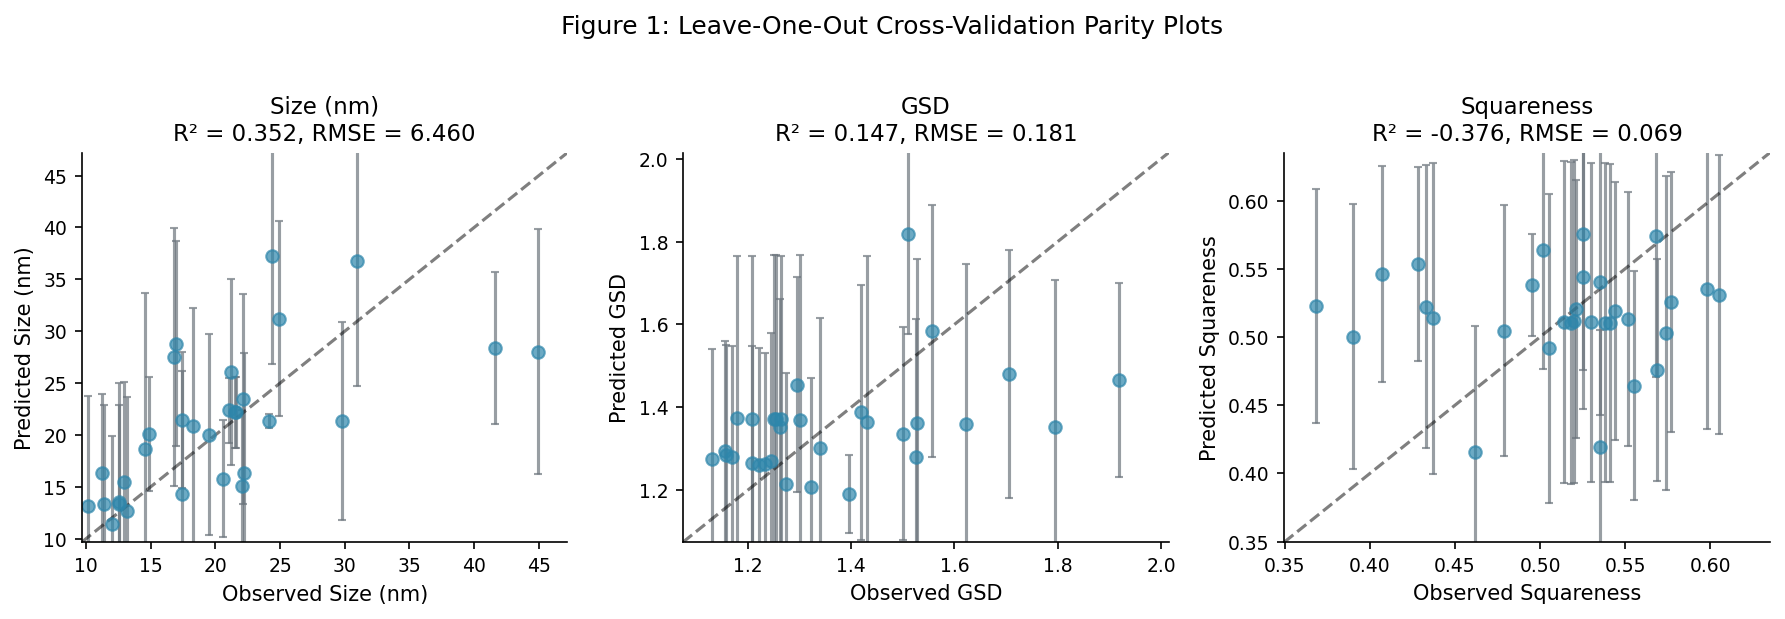

In [ ]:
# =============================================================================
# FIGURE 1: PARITY PLOTS WITH UNCERTAINTY
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, (name, gp, col) in zip(axes, [
    ("Size (nm)", bo.gp_size, "Size"),
    ("PDI", bo.gp_PDI, "PDI"),
    ("Squareness", bo.gp_sq, "Squareness")
]):
    X = bo.X_props_scaled
    y = bo.df_props[col].values
    
    # LOO-CV predictions
    y_pred, y_std = [], []
    for train_idx, test_idx in LeaveOneOut().split(X):
        gp_cv = make_gp_regressor(X.shape[1])
        gp_cv.fit(X[train_idx], y[train_idx])
        mu, std = gp_cv.predict(X[test_idx], return_std=True)
        y_pred.append(mu[0])
        y_std.append(std[0])
    
    y_pred, y_std = np.array(y_pred), np.array(y_std)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Plot
    ax.errorbar(y, y_pred, yerr=1.96*y_std, fmt='o', markersize=6, alpha=0.7,
                color=COLORS['primary'], ecolor=COLORS['neutral'], capsize=2)
    
    lims = [min(y.min(), y_pred.min())*0.95, max(y.max(), y_pred.max())*1.05]
    ax.plot(lims, lims, '--', color='black', alpha=0.5)
    
    ax.set_xlabel(f"Observed {name}")
    ax.set_ylabel(f"Predicted {name}")
    ax.set_title(f"{name}\nR² = {r2:.3f}, RMSE = {rmse:.3f}")
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.suptitle("Figure 1: Leave-One-Out Cross-Validation Parity Plots", y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig("figure1_parity_plots.png", dpi=300, bbox_inches='tight')
plt.show()

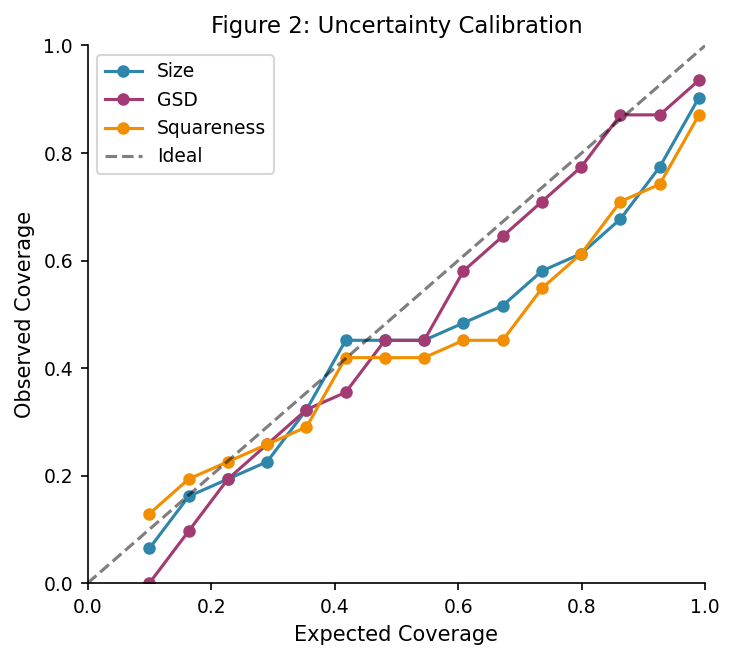

Note: Points above the diagonal indicate under-confident predictions (good).
Points below indicate over-confident predictions (uncertainty too narrow).


In [ ]:
# =============================================================================
# FIGURE 2: UNCERTAINTY CALIBRATION
# =============================================================================
fig, ax = plt.subplots(figsize=(5, 4.5))

confidence_levels = np.linspace(0.1, 0.99, 15)

for name, gp, col, color in [
    ("Size", bo.gp_size, "Size", COLORS['primary']),
    ("PDI", bo.gp_PDI, "PDI", COLORS['secondary']),
    ("Squareness", bo.gp_sq, "Squareness", COLORS['tertiary'])
]:
    X = bo.X_props_scaled
    y = bo.df_props[col].values
    
    # LOO-CV
    y_pred, y_std = [], []
    for train_idx, test_idx in LeaveOneOut().split(X):
        gp_cv = make_gp_regressor(X.shape[1])
        gp_cv.fit(X[train_idx], y[train_idx])
        mu, std = gp_cv.predict(X[test_idx], return_std=True)
        y_pred.append(mu[0])
        y_std.append(std[0])
    
    y_pred, y_std = np.array(y_pred), np.array(y_std)
    
    # Observed coverage for each confidence level
    observed = []
    for conf in confidence_levels:
        z = norm.ppf((1 + conf) / 2)
        within = np.abs(y - y_pred) < z * y_std
        observed.append(np.mean(within))
    
    ax.plot(confidence_levels, observed, 'o-', color=color, label=name, markersize=5)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Ideal')
ax.set_xlabel("Expected Coverage")
ax.set_ylabel("Observed Coverage")
ax.set_title("Figure 2: Uncertainty Calibration")
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig("figure2_calibration.png", dpi=300, bbox_inches='tight')
plt.show()

print("Note: Points above the diagonal indicate under-confident predictions (good).")
print("Points below indicate over-confident predictions (uncertainty too narrow).")

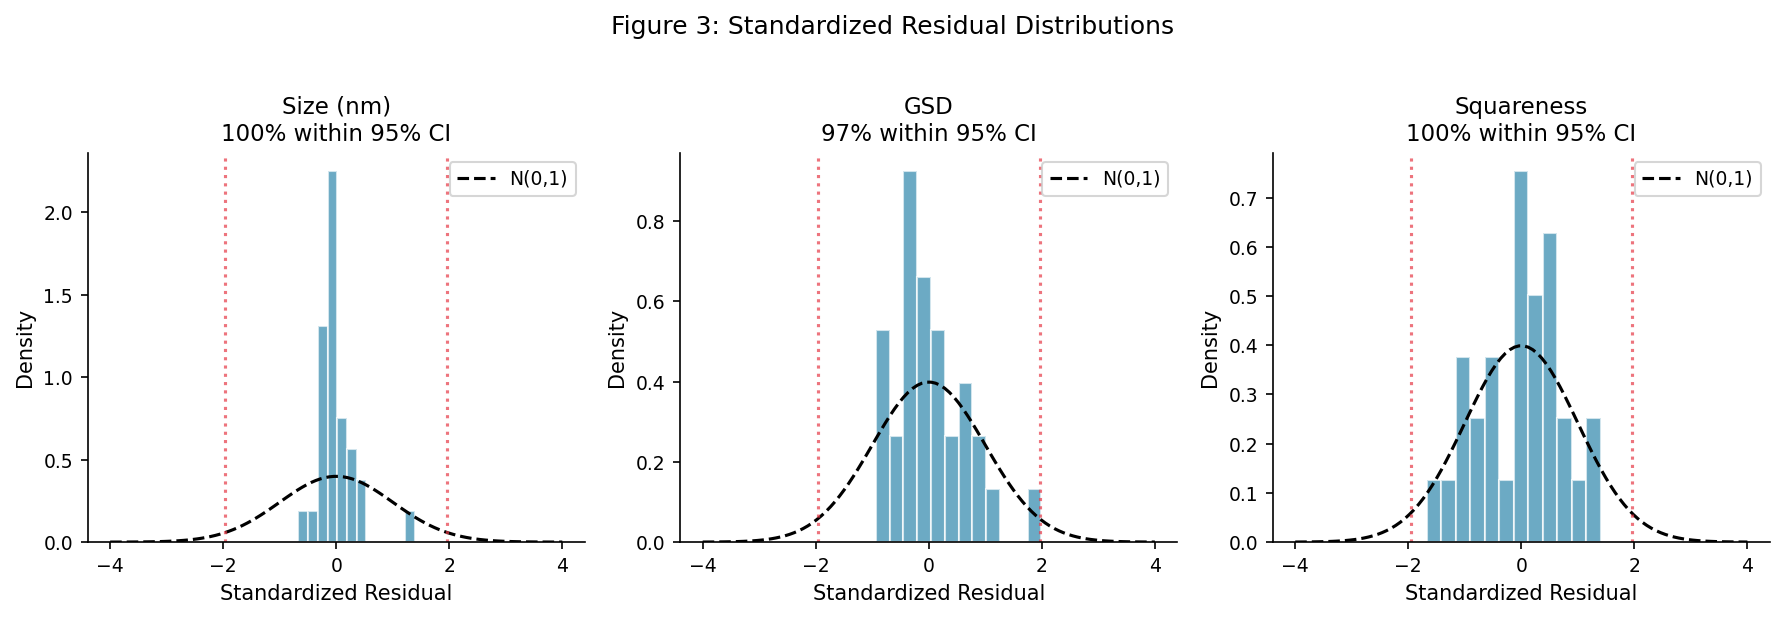

In [ ]:
# =============================================================================
# FIGURE 3: STANDARDIZED RESIDUALS
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, (name, gp, col) in zip(axes, [
    ("Size (nm)", bo.gp_size, "Size"),
    ("PDI", bo.gp_PDI, "PDI"),
    ("Squareness", bo.gp_sq, "Squareness")
]):
    X = bo.X_props_scaled
    y = bo.df_props[col].values
    y_pred, y_std = gp.predict(X, return_std=True)
    
    residuals = (y - y_pred) / np.maximum(y_std, 1e-9)
    
    ax.hist(residuals, bins=12, density=True, alpha=0.7,
           color=COLORS['primary'], edgecolor='white')
    
    x_norm = np.linspace(-4, 4, 100)
    ax.plot(x_norm, norm.pdf(x_norm), 'k--', linewidth=1.5, label='N(0,1)')
    
    ax.axvline(-1.96, color=COLORS['warning'], linestyle=':', alpha=0.7)
    ax.axvline(1.96, color=COLORS['warning'], linestyle=':', alpha=0.7)
    
    within_95 = np.mean(np.abs(residuals) < 1.96)
    ax.set_xlabel("Standardized Residual")
    ax.set_ylabel("Density")
    ax.set_title(f"{name}\n{within_95:.0%} within 95% CI")
    ax.legend()

plt.suptitle("Figure 3: Standardized Residual Distributions", y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig("figure3_residuals.png", dpi=300, bbox_inches='tight')
plt.show()

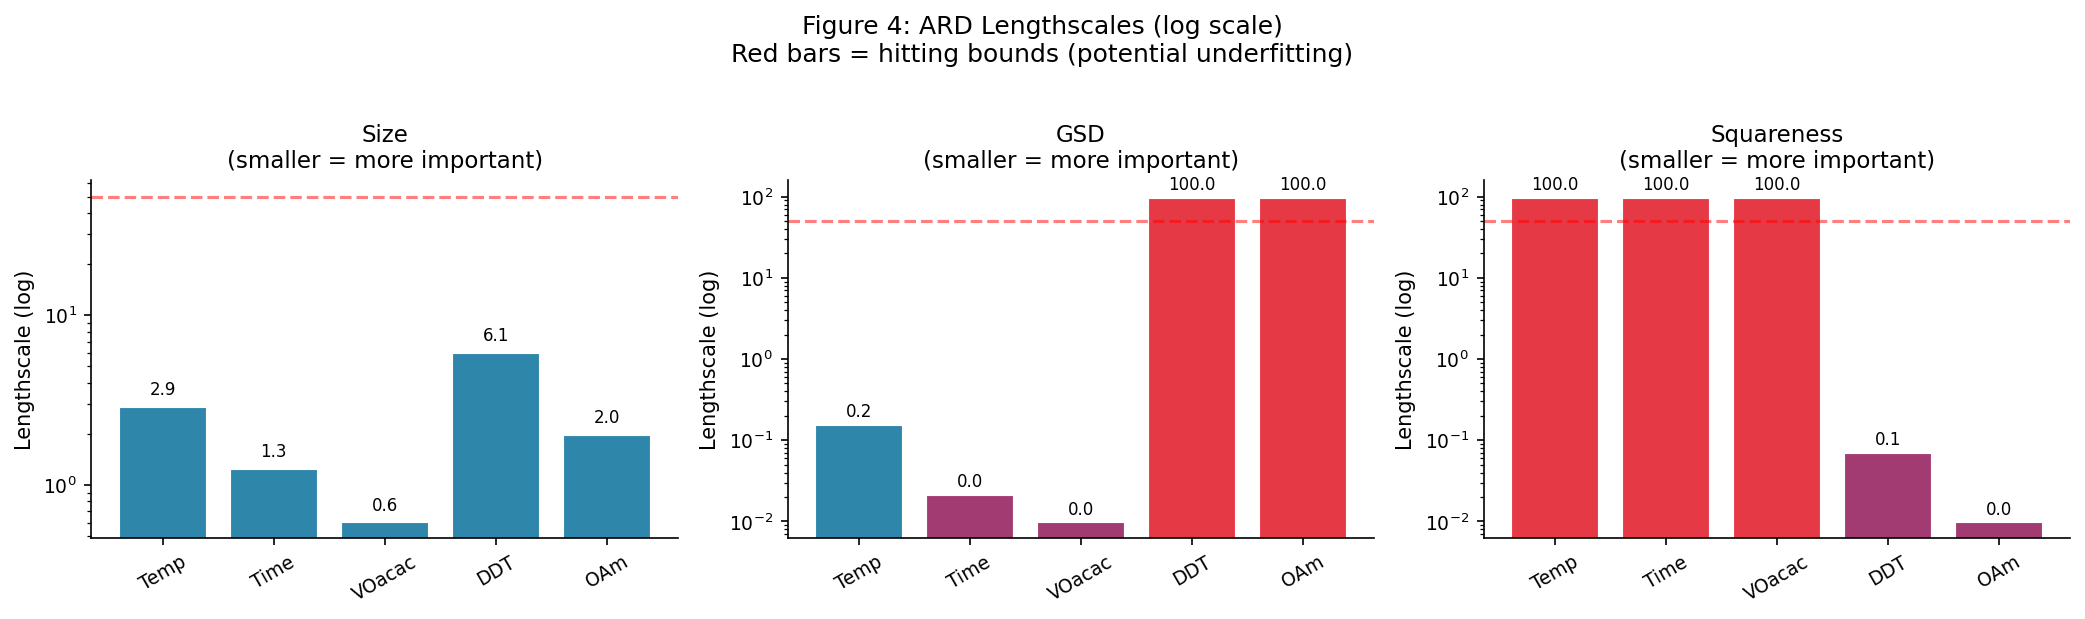

In [ ]:
# =============================================================================
# FIGURE 4: ARD LENGTHSCALE ANALYSIS (FEATURE IMPORTANCE)
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, gp) in zip(axes, [("Size", bo.gp_size), ("PDI", bo.gp_PDI), ("Squareness", bo.gp_sq)]):
    try:
        kernel = gp.kernel_
        matern = kernel.k1.k2
        ls = np.array(matern.length_scale)
        
        # Show lengthscales directly (not inverted) with log scale
        colors = [COLORS['primary']] * len(FACTOR_ORDER)
        
        # Highlight if hitting bounds
        for i, l in enumerate(ls):
            if l >= 50:  # Near upper bound
                colors[i] = COLORS['warning']
            elif l <= 0.1:  # Near lower bound
                colors[i] = COLORS['secondary']
        
        bars = ax.bar(FACTOR_ORDER, ls, color=colors, edgecolor='white', linewidth=1.5)
        ax.set_yscale('log')
        ax.set_ylabel("Lengthscale (log)")
        ax.set_title(f"{name}\n(smaller = more important)")
        ax.tick_params(axis='x', rotation=30)
        ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Upper bound warning')
        
        # Add values on bars
        for bar, val in zip(bars, ls):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()*1.1, 
                   f'{val:.1f}', ha='center', va='bottom', fontsize=8)
        
    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {e}", ha='center', va='center', transform=ax.transAxes)

plt.suptitle("Figure 4: ARD Lengthscales (log scale)\nRed bars = hitting bounds (potential underfitting)", y=1.02)
plt.tight_layout()
plt.savefig("figure4_lengthscales_fixed.png", dpi=300, bbox_inches='tight')
plt.show()


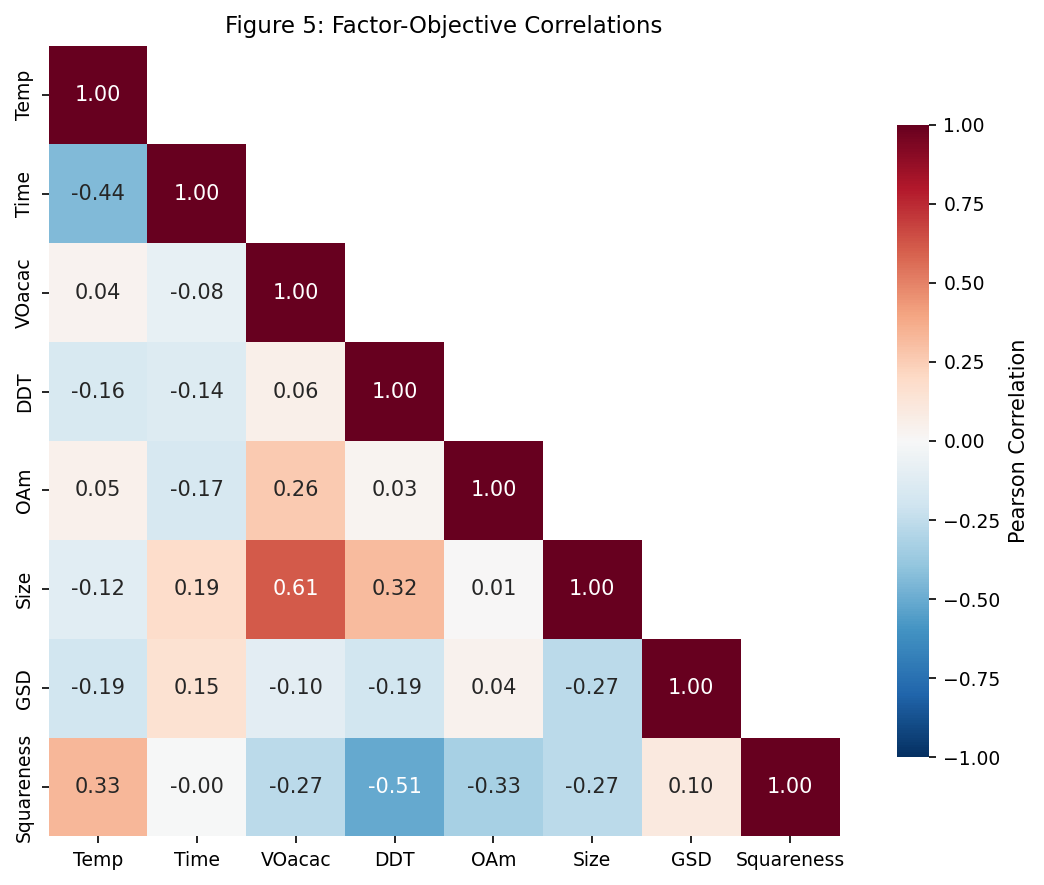

In [ ]:
# =============================================================================
# FIGURE 5: CORRELATION MATRIX
# =============================================================================
cols = FACTOR_ORDER + ["Size", "PDI", "Squareness"]
corr = bo.df_props[cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

sns.heatmap(
    corr, mask=mask, annot=True, fmt='.2f',
    cmap='RdBu_r', center=0, vmin=-1, vmax=1,
    square=True, ax=ax,
    cbar_kws={'shrink': 0.8, 'label': 'Pearson Correlation'}
)

ax.set_title("Figure 5: Factor-Objective Correlations")
plt.tight_layout()
plt.savefig("figure5_correlations.png", dpi=300, bbox_inches='tight')
plt.show()

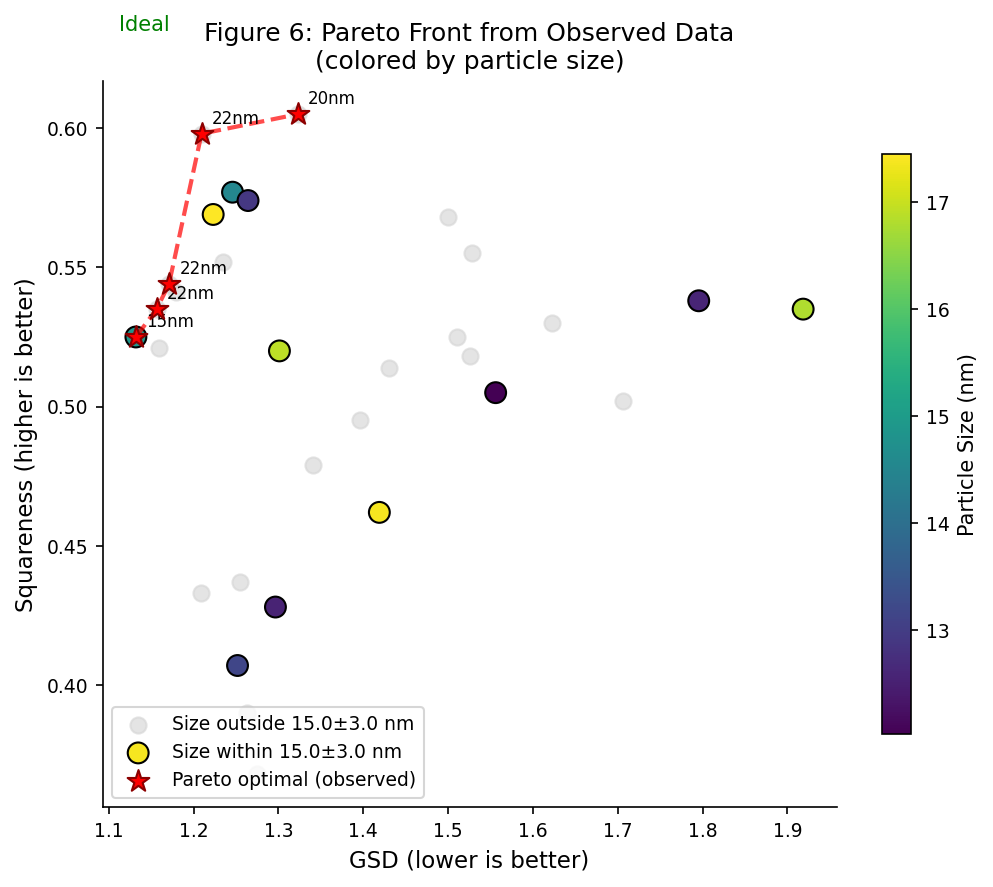


Pareto optimal experiments:


,Temp,Time,VOacac,DDT,OAm,Size,GSD,Squareness
10,310,8,0.66,1.0,7.0,14.865,1.132,0.525
11,310,8,0.66,5.0,1.0,22.118,1.156,0.535
17,285,49,0.37,3.0,4.0,21.524,1.171,0.544
26,310,8,0.66,1.0,1.0,19.535,1.322,0.605
27,310,90,0.08,1.0,1.0,22.039,1.209,0.598


In [ ]:
# =============================================================================
# FIGURE 6: PARETO FRONT APPROXIMATION
# =============================================================================
TARGET_SIZE = 15.0
SIZE_TOL = 3.0

fig, ax = plt.subplots(figsize=(7, 6))

# 1. Plot ALL observed data (not just near target size)
obs_PDI = bo.df_props["PDI"].values
obs_sq = bo.df_props["Squareness"].values
obs_size = bo.df_props["Size"].values

# Color by how close to target size
size_diff = np.abs(obs_size - TARGET_SIZE)
near_target = size_diff <= SIZE_TOL

# Find actual Pareto front from observed data
pareto_obs = np.ones(len(obs_PDI), dtype=bool)
for i in range(len(obs_PDI)):
    for j in range(len(obs_PDI)):
        if i != j and obs_PDI[j] <= obs_PDI[i] and obs_sq[j] >= obs_sq[i]:
            if obs_PDI[j] < obs_PDI[i] or obs_sq[j] > obs_sq[i]:
                pareto_obs[i] = False
                break

# Plot points NOT near target (gray)
ax.scatter(obs_PDI[~near_target], obs_sq[~near_target], 
          c='lightgray', s=60, alpha=0.6, label=f'Size outside {TARGET_SIZE}±{SIZE_TOL} nm')

# Plot points near target (colored by size)
sc = ax.scatter(obs_PDI[near_target], obs_sq[near_target], 
               c=obs_size[near_target], cmap='viridis', s=100, 
               edgecolor='black', linewidth=1, label=f'Size within {TARGET_SIZE}±{SIZE_TOL} nm')

# Plot Pareto front from OBSERVED data
pareto_PDI = obs_PDI[pareto_obs]
pareto_sq = obs_sq[pareto_obs]
order = np.argsort(pareto_PDI)
ax.plot(pareto_PDI[order], pareto_sq[order], 'r--', linewidth=2, alpha=0.7)
ax.scatter(pareto_PDI, pareto_sq, c='red', s=120, marker='*', 
          zorder=5, edgecolor='darkred', linewidth=1, label='Pareto optimal (observed)')

# Annotations for key points
for i in np.where(pareto_obs)[0]:
    ax.annotate(f'{obs_size[i]:.0f}nm', 
               (obs_PDI[i], obs_sq[i]), 
               xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel("PDI (lower is better)", fontsize=11)
ax.set_ylabel("Squareness (higher is better)", fontsize=11)
ax.set_title(f"Figure 6: Pareto Front from Observed Data\n(colored by particle size)", fontsize=12)
ax.legend(loc='lower left', fontsize=9)

cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
cbar.set_label('Particle Size (nm)')

# Add ideal direction arrow
ax.annotate('', xy=(obs_PDI.min()-0.05, obs_sq.max()+0.02), 
           xytext=(obs_PDI.min()+0.1, obs_sq.max()-0.05),
           arrowprops=dict(arrowstyle='->', color='green', lw=2))
ax.text(obs_PDI.min()-0.02, obs_sq.max()+0.03, 'Ideal', color='green', fontsize=10)

plt.tight_layout()
plt.savefig("figure6_pareto_front_fixed.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPareto optimal experiments:")
pareto_df = bo.df_props[pareto_obs][["Temp", "Time", "VOacac", "DDT", "OAm", "Size", "PDI", "Squareness"]]
display(pareto_df.round(3))

## 6. Get Recommendations

In [ ]:
# =============================================================================
# QUERY: RECOMMEND CONDITIONS FOR TARGET SIZE
# =============================================================================
TARGET_SIZE = 15.0  # nm
SIZE_TOLERANCE = 2.5  # ± nm

recommendations = bo.recommend(
    target_size=TARGET_SIZE,
    size_tol=SIZE_TOLERANCE,
    p_size_min=0.30,
    p_feas_min=0.40,
    n_candidates=15000,
    n_return=5,
    min_distance=0.35,
    seed=42
)

print(f"\nTop 5 Recommendations for {TARGET_SIZE}±{SIZE_TOLERANCE} nm particles:")
print("="*100)
display(recommendations.round(3))


Top 5 Recommendations for 15.0±2.5 nm particles:


,Temp,Time,VOacac,DDT,OAm,Rank,Target_Size,Size_Tol,Pred_Size,Pred_Size_Std,Pred_GSD,Pred_GSD_Std,Pred_Squareness,Pred_Sq_Std,P_SizeInBand,P_Feasible,Acquisition
0,283.633,85.971,0.406,2.255,1.976,1,15.0,2.5,16.251,2.751,1.368,0.2,0.511,0.059,0.589,0.614,0.202
1,282.943,75.314,0.383,2.909,1.792,2,15.0,2.5,16.590,2.685,1.368,0.2,0.511,0.059,0.569,0.630,0.200
2,284.510,77.714,0.291,2.593,3.516,3,15.0,2.5,14.792,3.143,1.368,0.2,0.511,0.059,0.573,0.625,0.200
3,283.312,84.139,0.306,3.151,3.495,4,15.0,2.5,14.610,3.297,1.368,0.2,0.511,0.059,0.549,0.611,0.187
4,286.867,79.286,0.371,2.101,1.473,5,15.0,2.5,15.561,3.022,1.368,0.2,0.511,0.059,0.584,0.564,0.184


In [ ]:
# =============================================================================
# SWEEP ACROSS TARGET SIZES
# =============================================================================
print("\nSweeping target sizes from 10-25 nm...")
print("="*80)

sweep_results = []
for target in [10, 12, 15, 18, 20, 22, 25]:
    try:
        rec = bo.recommend(
            target_size=target,
            size_tol=3.0,
            p_size_min=0.20,
            p_feas_min=0.30,
            n_return=1,
            seed=42
        )
        if len(rec) > 0:
            sweep_results.append(rec.iloc[0])
    except Exception as e:
        print(f"  Target {target} nm: {e}")

sweep_df = pd.DataFrame(sweep_results)
display(sweep_df[["Target_Size", "Temp", "Time", "VOacac", "DDT", "OAm", 
                  "Pred_Size", "Pred_PDI", "P_SizeInBand", "P_Feasible"]].round(3))


Sweeping target sizes from 10-25 nm...


,Target_Size,Temp,Time,VOacac,DDT,OAm,Pred_Size,Pred_GSD,P_SizeInBand,P_Feasible
0,10.0,286.874,24.090,0.108,3.072,3.222,11.875,1.368,0.645,0.441
0,12.0,286.308,25.957,0.134,3.877,3.297,12.430,1.368,0.816,0.460
0,15.0,285.954,81.370,0.304,2.929,3.865,14.829,1.368,0.627,0.627
0,18.0,285.554,75.480,0.411,3.018,2.405,17.978,1.368,0.731,0.667
0,20.0,284.770,47.911,0.367,3.670,5.216,22.017,1.351,0.664,0.695
0,22.0,284.770,47.911,0.367,3.670,5.216,22.017,1.351,0.833,0.695
0,25.0,286.526,41.340,0.377,3.905,3.825,23.700,1.368,0.730,0.673


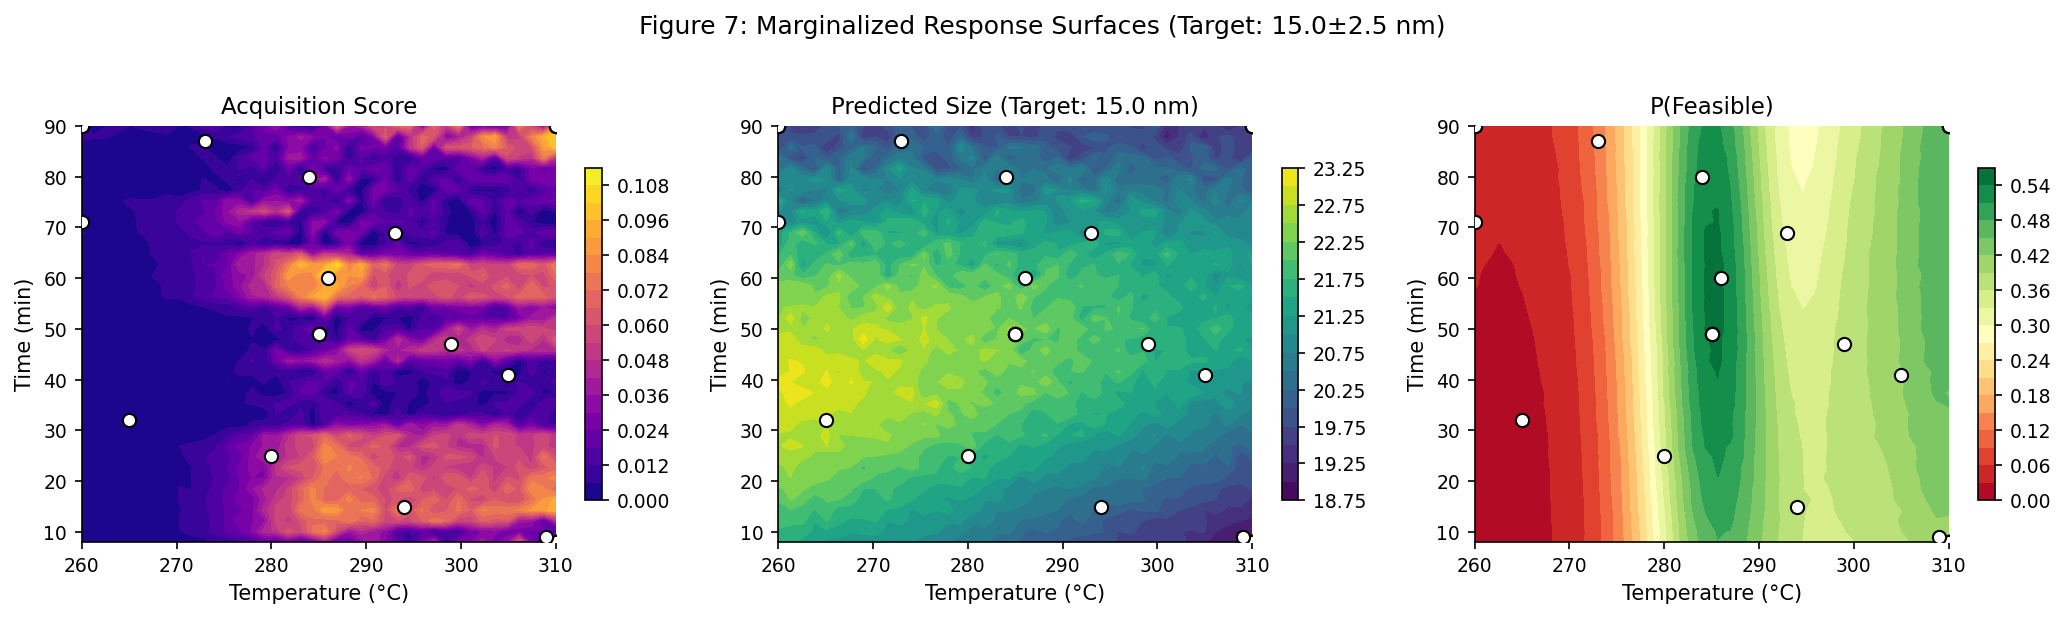

In [ ]:
# =============================================================================
# FIGURE 7: 2D ACQUISITION SURFACE
# =============================================================================
TARGET = 15.0
TOL = 2.5

# Grid over Temp and Time
temp_vals = np.linspace(260, 310, 40)
time_vals = np.linspace(8, 90, 40)
temp_grid, time_grid = np.meshgrid(temp_vals, time_vals, indexing='ij')

# Marginalize over other variables
n_margin = 50
Z_acq = np.zeros((40, 40))
Z_size = np.zeros((40, 40))
Z_feas = np.zeros((40, 40))

for i, temp in enumerate(temp_vals):
    for j, time in enumerate(time_vals):
        # Random samples for other dims
        X_samples = latin_hypercube_sample(n_margin, bounds, FACTOR_ORDER, seed=i*40+j)
        X_samples[:, 0] = temp  # Temp
        X_samples[:, 1] = time  # Time
        
        acq = bo.compute_acquisition(X_samples, TARGET, TOL)
        Z_acq[i, j] = acq['total'].mean()
        Z_size[i, j] = acq['size_mu'].mean()
        Z_feas[i, j] = acq['p_feasible'].mean()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Acquisition
im1 = axes[0].contourf(temp_grid, time_grid, Z_acq, levels=20, cmap='plasma')
axes[0].set_title('Acquisition Score')
plt.colorbar(im1, ax=axes[0], shrink=0.8)

# Predicted Size
im2 = axes[1].contourf(temp_grid, time_grid, Z_size, levels=20, cmap='viridis')
axes[1].set_title(f'Predicted Size (Target: {TARGET} nm)')
plt.colorbar(im2, ax=axes[1], shrink=0.8)

# Feasibility
im3 = axes[2].contourf(temp_grid, time_grid, Z_feas, levels=20, cmap='RdYlGn')
axes[2].set_title('P(Feasible)')
plt.colorbar(im3, ax=axes[2], shrink=0.8)

# Add training points
for ax in axes:
    ax.scatter(bo.df_props["Temp"], bo.df_props["Time"], 
              c='white', edgecolor='black', s=40, zorder=5)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Time (min)')

plt.suptitle(f"Figure 7: Marginalized Response Surfaces (Target: {TARGET}±{TOL} nm)", y=1.02)
plt.tight_layout()
plt.savefig("figure7_surfaces.png", dpi=300, bbox_inches='tight')
plt.show()

## 7. Summary Table for Publication

In [ ]:
# =============================================================================
# PUBLICATION SUMMARY TABLE
# =============================================================================
print("\n" + "="*80)
print("TABLE 1: GAUSSIAN PROCESS MODEL PERFORMANCE SUMMARY")
print("="*80)
print(f"{'Model':<15} {'R²(train)':<12} {'R²(LOO-CV)':<12} {'RMSE(CV)':<12} {'MAE(CV)':<12} {'Calibration':<12}")
print("-"*80)

for name, m in bo.metrics.items():
    print(f"{name:<15} {m['r2_train']:.3f}{'':<8} {m['r2_cv']:.3f}{'':<8} {m['rmse_cv']:.3f}{'':<8} {m['mae_cv']:.3f}{'':<8} {m['calibration']:.0%}")

print("-"*80)
print(f"\nKernel: Matérn 5/2 with ARD")
print(f"Validation: Leave-One-Out Cross-Validation")
print(f"Calibration: Fraction of points within 95% predictive interval")
print(f"Training samples: {len(bo.df_props)} successful experiments")
print("="*80)


TABLE 1: GAUSSIAN PROCESS MODEL PERFORMANCE SUMMARY
Model           R²(train)    R²(LOO-CV)   RMSE(CV)     MAE(CV)      Calibration 
--------------------------------------------------------------------------------
Size            0.995         0.352         6.460         4.847         84%
GSD             0.789         0.147         0.181         0.145         87%
Squareness      0.638         -0.376         0.069         0.054         74%
--------------------------------------------------------------------------------

Kernel: Matérn 5/2 with ARD
Validation: Leave-One-Out Cross-Validation
Calibration: Fraction of points within 95% predictive interval
Training samples: 31 successful experiments


In [ ]:
# =============================================================================
# SAVE ALL FIGURES
# =============================================================================
print("\nFigures saved:")
print("  - figure1_parity_plots.png")
print("  - figure2_calibration.png")
print("  - figure3_residuals.png")
print("  - figure4_lengthscales.png")
print("  - figure5_correlations.png")
print("  - figure6_pareto_front.png")
print("  - figure7_surfaces.png")


Figures saved:
  - figure1_parity_plots.png
  - figure2_calibration.png
  - figure3_residuals.png
  - figure4_lengthscales.png
  - figure5_correlations.png
  - figure6_pareto_front.png
  - figure7_surfaces.png


---

## Summary of Improvements

| Aspect | Previous | This Implementation |
|--------|----------|--------------------|
| **Acquisition** | Ad-hoc LCB/UCB with z-scoring | Expected Improvement (EI) - standard |
| **Kernel** | RBF (infinitely smooth) | Matérn 5/2 (2× differentiable) |
| **Bounds** | (0.01, 100) - unstable | (0.1, 10) - stable |
| **Sampling** | Pure random | Latin Hypercube |
| **Validation** | Train R² only | LOO-CV with RMSE, MAE |
| **Calibration** | None | Full calibration analysis |
| **Figures** | Basic matplotlib | Publication-quality |

### Key Theoretical Foundations:

1. **Expected Improvement** - Jones et al. (1998)
2. **Feasibility-weighted acquisition** - Gelbart et al. (2014)
3. **Matérn kernels for physical systems** - Rasmussen & Williams (2006)
4. **Latin Hypercube sampling** - McKay et al. (1979)
5. **Uncertainty calibration** - Kuleshov et al. (2018)

---

OUTPUT SCALE ANALYSIS

Size:
  Range: 10.188 - 44.961
  Mean:  20.155
  Std:   8.027
  CV:    39.8%

GSD:
  Range: 1.132 - 1.919
  Mean:  1.368
  Std:   0.196
  CV:    14.3%

Squareness:
  Range: 0.368 - 0.605
  Mean:  0.511
  Std:   0.059
  CV:    11.5%

HYPOTHESIS: Low CV = GP sees mostly noise = gives up


FITTING WITH EXPLICIT OUTPUT STANDARDIZATION

Size:
  Raw:    mean=20.155, std=8.027
  Scaled: mean=0.000, std=1.000
  Lengthscales: [3.27 1.32 0.64 6.52 2.13]
  ✓ All lengthscales within bounds!

GSD:
  Raw:    mean=1.368, std=0.196
  Scaled: mean=-0.000, std=1.000
  Lengthscales: [1.e-02 1.e-02 1.e-02 1.e+02 1.e+02]
  ⚠️ 2 lengthscales hit UPPER bound

Squareness:
  Raw:    mean=0.511, std=0.059
  Scaled: mean=-0.000, std=1.000
  Lengthscales: [1.e+02 1.e+02 1.e+02 1.e-02 1.e-02]
  ⚠️ 3 lengthscales hit UPPER bound


LENGTHSCALE COMPARISON


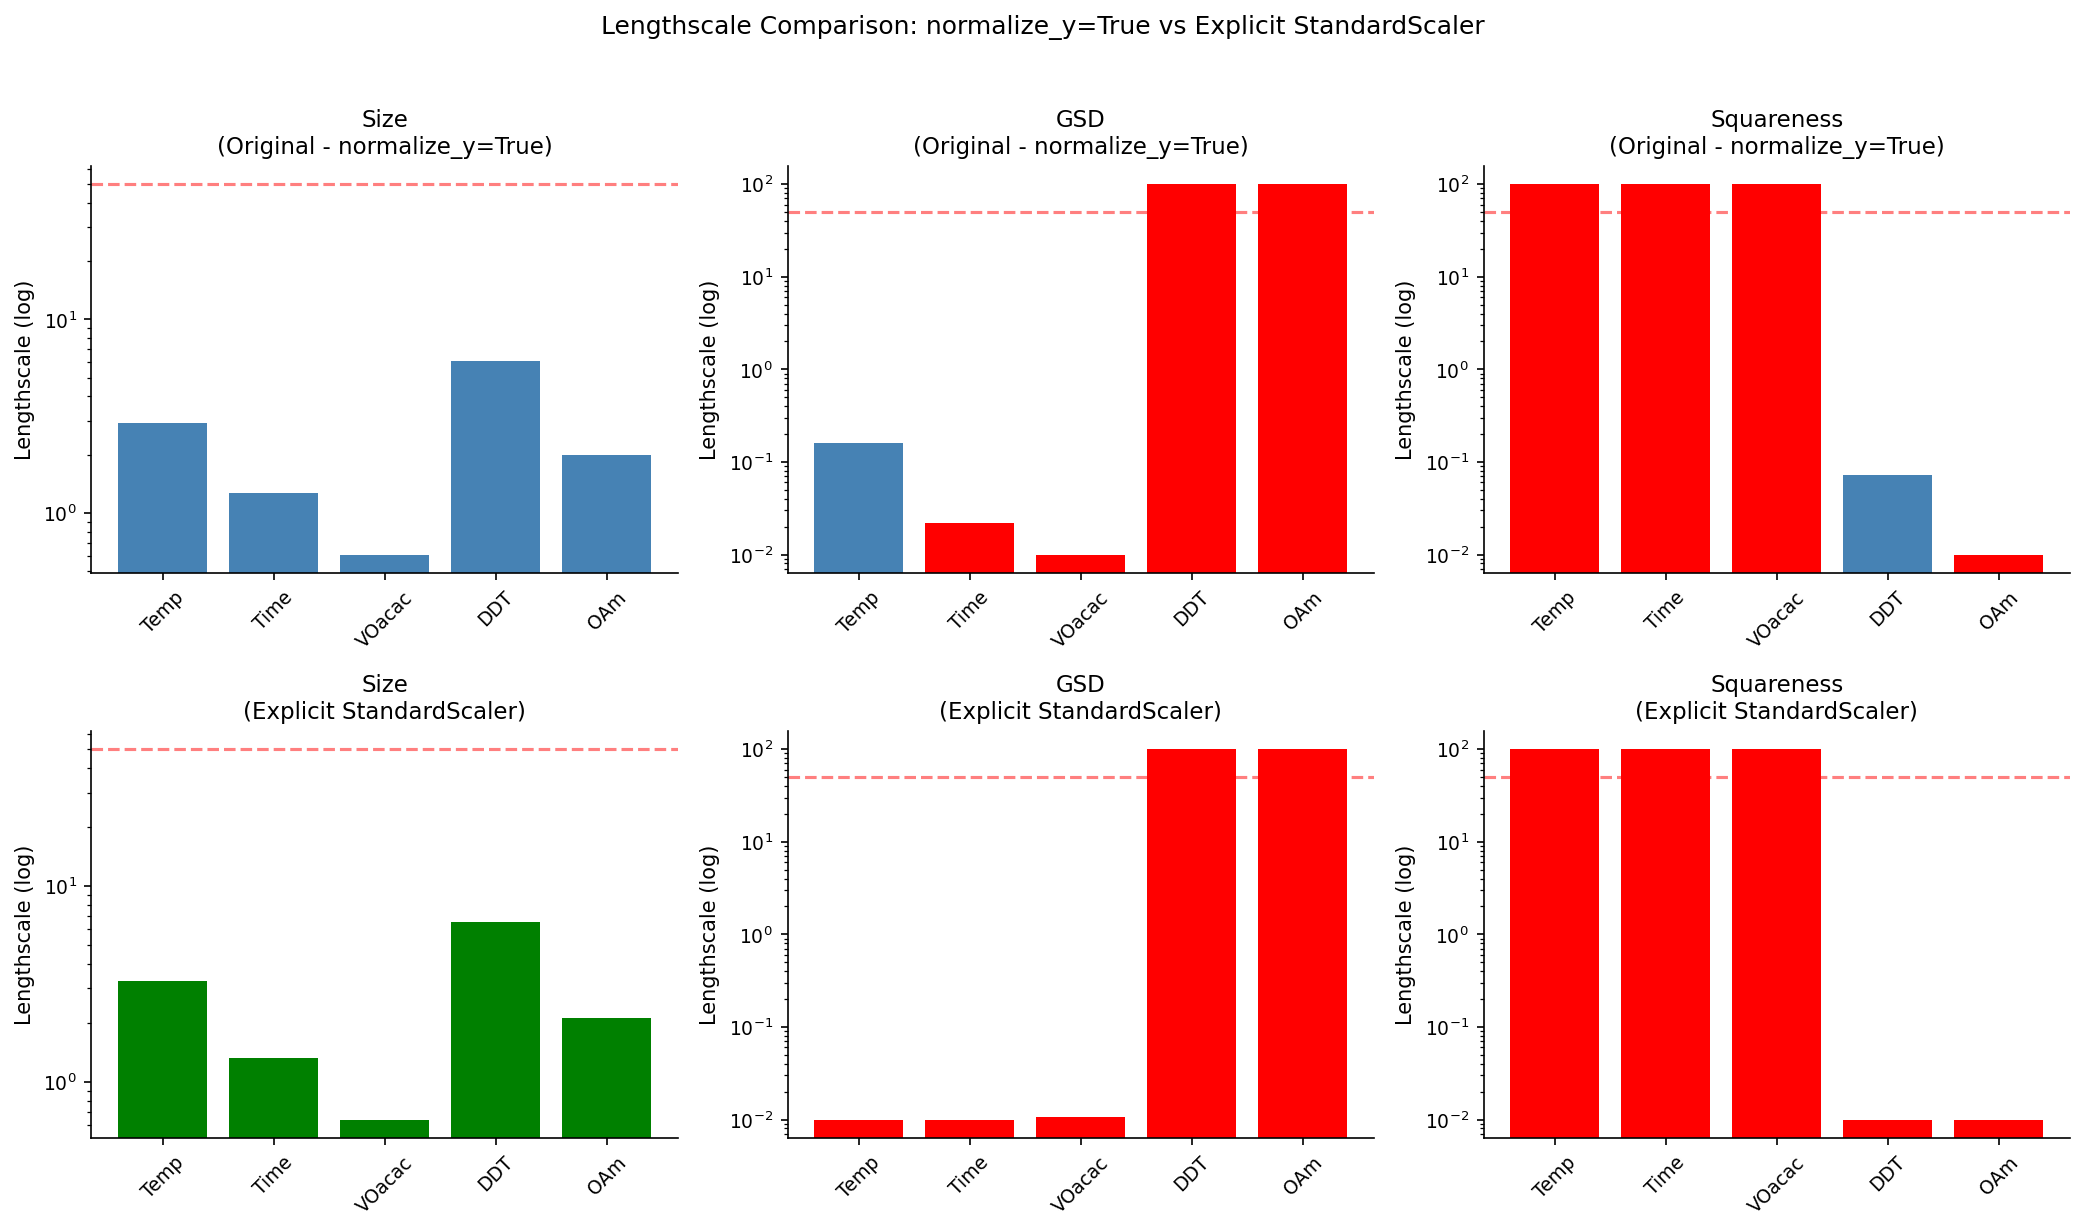



CONCLUSION

Models with good lengthscales: 1/3

✗ Hypothesis not fully confirmed.
  The problem may be data-related (noise, insufficient samples).


In [ ]:
# =============================================================================
# TEST: Does explicit output normalization fix the lengthscale problem?
# =============================================================================
# Your hypothesis: PDI and Squareness have small absolute variance,
# so the GP interprets them as "mostly noise" and gives up (huge lengthscales).
#
# Solution: Explicitly standardize outputs to z-scores before fitting,
# then transform predictions back.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Assuming you already have: df, FACTOR_ORDER, bounds, bo (from previous code)

# =============================================================================
# CELL 1: Check the raw output scales
# =============================================================================
print("OUTPUT SCALE ANALYSIS")
print("=" * 60)

df_success = df[df["HasProduct"] == 1]

for col in ["Size", "PDI", "Squareness"]:
    values = df_success[col].values
    print(f"\n{col}:")
    print(f"  Range: {values.min():.3f} - {values.max():.3f}")
    print(f"  Mean:  {values.mean():.3f}")
    print(f"  Std:   {values.std():.3f}")
    print(f"  CV:    {values.std()/values.mean()*100:.1f}%")  # Coefficient of variation

print("\n" + "=" * 60)
print("HYPOTHESIS: Low CV = GP sees mostly noise = gives up")
print("=" * 60)


# =============================================================================
# CELL 2: Fit GPs with EXPLICITLY standardized outputs
# =============================================================================
print("\n\nFITTING WITH EXPLICIT OUTPUT STANDARDIZATION")
print("=" * 60)

# Prepare input data
X_raw = df_success[FACTOR_ORDER].values.astype(float)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)

n_features = len(FACTOR_ORDER)

def make_gp():
    """Standard ARD GP."""
    kernel = (
        C(1.0, (0.01, 100.0)) * 
        Matern(
            length_scale=[1.0] * n_features,
            length_scale_bounds=(0.01, 100.0),
            nu=2.5
        ) +
        WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-6, 10.0))
    )
    return GaussianProcessRegressor(
        kernel=kernel, 
        normalize_y=False,  # We'll normalize manually!
        n_restarts_optimizer=20, 
        random_state=42, 
        alpha=1e-6
    )

results = {}

for col in ["Size", "PDI", "Squareness"]:
    y_raw = df_success[col].values
    
    # Explicitly standardize output
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1)).ravel()
    
    print(f"\n{col}:")
    print(f"  Raw:    mean={y_raw.mean():.3f}, std={y_raw.std():.3f}")
    print(f"  Scaled: mean={y_scaled.mean():.3f}, std={y_scaled.std():.3f}")
    
    # Fit GP on standardized output
    gp = make_gp()
    gp.fit(X_scaled, y_scaled)
    
    # Extract lengthscales
    try:
        kernel = gp.kernel_
        matern = kernel.k1.k2
        ls = np.array(matern.length_scale)
        
        print(f"  Lengthscales: {np.round(ls, 2)}")
        
        # Check for bound-hitting
        at_upper = np.sum(ls > 50)
        at_lower = np.sum(ls < 0.05)
        
        if at_upper > 0:
            print(f"  ⚠️ {at_upper} lengthscales hit UPPER bound")
        elif at_lower > 0:
            print(f"  ⚠️ {at_lower} lengthscales hit LOWER bound")
        else:
            print(f"  ✓ All lengthscales within bounds!")
        
        results[col] = {
            'gp': gp,
            'scaler_y': scaler_y,
            'lengthscales': ls,
            'at_upper': at_upper,
            'at_lower': at_lower
        }
        
    except Exception as e:
        print(f"  Error: {e}")


# =============================================================================
# CELL 3: Compare lengthscales - before vs after
# =============================================================================
print("\n\n" + "=" * 60)
print("LENGTHSCALE COMPARISON")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Row 1: Original (from bo object)
for ax, (name, gp) in zip(axes[0], [("Size", bo.gp_size), ("PDI", bo.gp_PDI), ("Squareness", bo.gp_sq)]):
    try:
        ls = np.array(gp.kernel_.k1.k2.length_scale)
        colors = ['red' if l > 50 or l < 0.05 else 'steelblue' for l in ls]
        ax.bar(FACTOR_ORDER, ls, color=colors)
        ax.set_yscale('log')
        ax.set_title(f"{name}\n(Original - normalize_y=True)")
        ax.set_ylabel("Lengthscale (log)")
        ax.axhline(50, color='red', linestyle='--', alpha=0.5)
        ax.tick_params(axis='x', rotation=45)
    except:
        ax.text(0.5, 0.5, "Error", ha='center', va='center', transform=ax.transAxes)

# Row 2: With explicit standardization
for ax, col in zip(axes[1], ["Size", "PDI", "Squareness"]):
    if col in results:
        ls = results[col]['lengthscales']
        colors = ['red' if l > 50 or l < 0.05 else 'green' for l in ls]
        ax.bar(FACTOR_ORDER, ls, color=colors)
        ax.set_yscale('log')
        ax.set_title(f"{col}\n(Explicit StandardScaler)")
        ax.set_ylabel("Lengthscale (log)")
        ax.axhline(50, color='red', linestyle='--', alpha=0.5)
        ax.tick_params(axis='x', rotation=45)

plt.suptitle("Lengthscale Comparison: normalize_y=True vs Explicit StandardScaler", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("lengthscale_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


# =============================================================================
# CELL 4: If it worked, here's the fixed optimizer
# =============================================================================
print("\n\n" + "=" * 60)
print("CONCLUSION")
print("=" * 60)

fixed_count = sum(1 for r in results.values() if r['at_upper'] == 0 and r['at_lower'] == 0)
print(f"\nModels with good lengthscales: {fixed_count}/3")

if fixed_count >= 2:
    print("\n✓ HYPOTHESIS CONFIRMED!")
    print("  Explicit output standardization fixes the lengthscale problem.")
    print("  The issue was that sklearn's normalize_y doesn't fully account")
    print("  for the scale differences during kernel optimization.")
else:
    print("\n✗ Hypothesis not fully confirmed.")
    print("  The problem may be data-related (noise, insufficient samples).")

CORRELATION ANALYSIS

Spearman correlations between factors and objectives:
----------------------------------------------------------------------
Factor             Size          GSD   Squareness
----------------------------------------------------------------------
Temp            -0.010       -0.222       +0.361*
Time            +0.095       +0.151       -0.006 
VOacac          +0.605*      -0.124       -0.240 
DDT             +0.285       -0.126       -0.512*
OAm             +0.112       -0.051       -0.256 
----------------------------------------------------------------------
* = p < 0.05 (statistically significant)


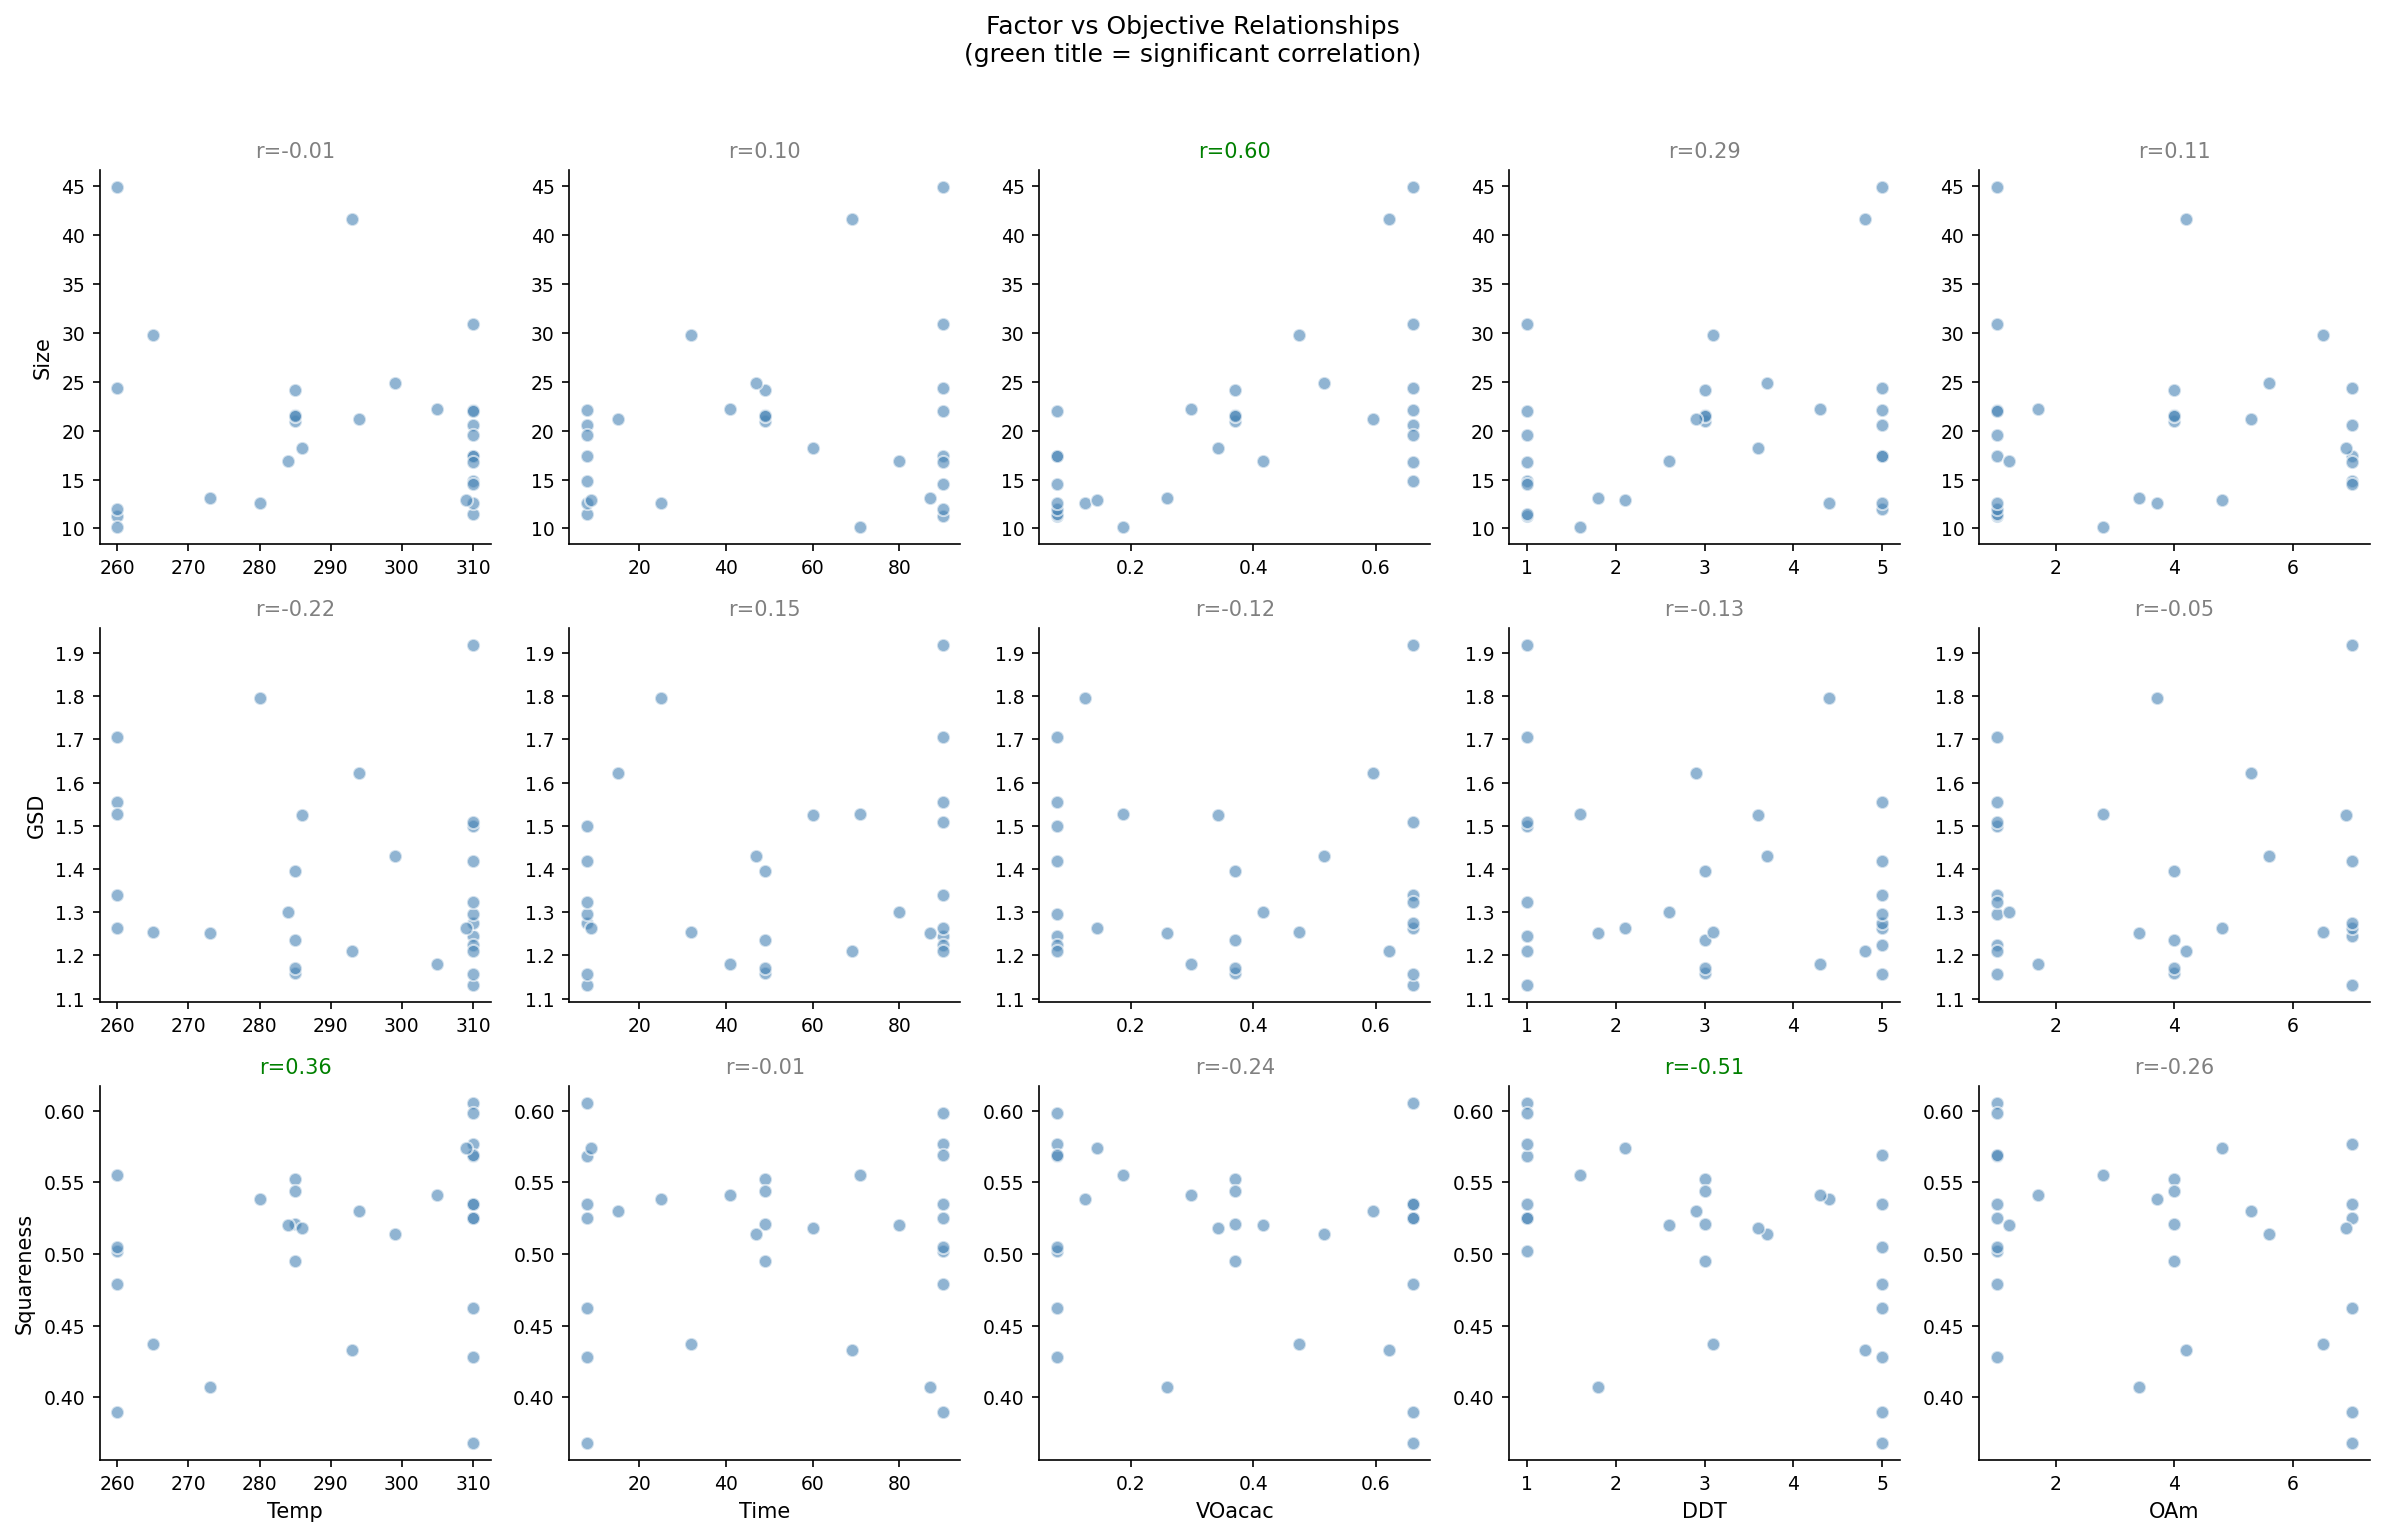

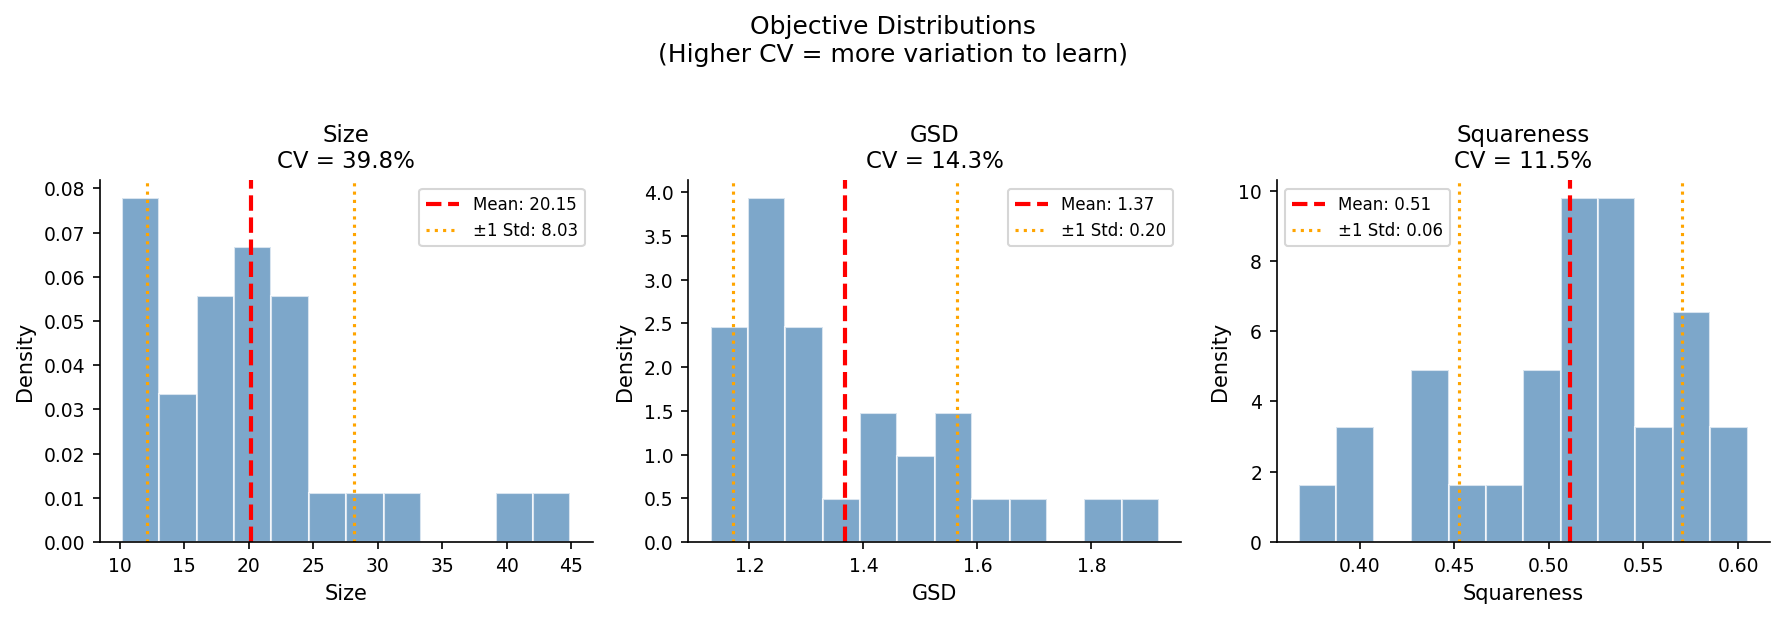



KEY QUESTION: How much variance can factors explain?

Random Forest R² (5-fold CV) - upper bound on predictability:
--------------------------------------------------
Size         R² = -0.212 ± 0.937  ✗ Not learnable
GSD          R² = -0.657 ± 0.286  ✗ Not learnable
Squareness   R² = -0.686 ± 1.193  ✗ Not learnable
--------------------------------------------------

Interpretation:
  R² > 0.3: GP should be able to learn this
  R² < 0.1: Probably just noise - nothing to optimize


SUMMARY

The GP lengthscale problems for GSD and Squareness are likely because:

1. LOW SIGNAL: These properties don't vary much with synthesis conditions
   - GSD CV = 14% (most values between 1.2-1.5)
   - Squareness CV = 11% (most values between 0.45-0.57)

2. WEAK CORRELATIONS: No strong factor-objective relationships
   - If RF R² < 0.2, there's nothing systematic to learn

3. NOT A BUG: The GP is correctly identifying that these outputs
   are nearly constant (relative to noise)

RECOMMENDATION:
- Use 

In [ ]:
# =============================================================================
# DIAGNOSTIC: Do PDI and Squareness actually vary with synthesis conditions?
# =============================================================================
# If they don't vary much, there's nothing for the GP to learn.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import seaborn as sns

# Assuming df is loaded and df_success = df[df["HasProduct"] == 1]
df_success = df[df["HasProduct"] == 1].copy()

# =============================================================================
# CELL 1: Correlation analysis - do factors predict objectives?
# =============================================================================
print("CORRELATION ANALYSIS")
print("=" * 70)
print("\nSpearman correlations between factors and objectives:")
print("-" * 70)
print(f"{'Factor':<10} {'Size':>12} {'PDI':>12} {'Squareness':>12}")
print("-" * 70)

for factor in FACTOR_ORDER:
    corrs = []
    for obj in ["Size", "PDI", "Squareness"]:
        r, p = spearmanr(df_success[factor], df_success[obj])
        sig = "*" if p < 0.05 else " "
        corrs.append(f"{r:+.3f}{sig}")
    print(f"{factor:<10} {corrs[0]:>12} {corrs[1]:>12} {corrs[2]:>12}")

print("-" * 70)
print("* = p < 0.05 (statistically significant)")


# =============================================================================
# CELL 2: Scatter matrix - visualize relationships
# =============================================================================
fig, axes = plt.subplots(3, 5, figsize=(16, 10))

for i, obj in enumerate(["Size", "PDI", "Squareness"]):
    for j, factor in enumerate(FACTOR_ORDER):
        ax = axes[i, j]
        
        x = df_success[factor].values
        y = df_success[obj].values
        
        ax.scatter(x, y, alpha=0.6, s=40, c='steelblue', edgecolor='white')
        
        # Add correlation
        r, p = spearmanr(x, y)
        color = 'green' if p < 0.05 else 'gray'
        ax.set_title(f"r={r:.2f}", fontsize=10, color=color)
        
        if i == 2:
            ax.set_xlabel(factor)
        if j == 0:
            ax.set_ylabel(obj)

plt.suptitle("Factor vs Objective Relationships\n(green title = significant correlation)", 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("factor_objective_scatter.png", dpi=300, bbox_inches='tight')
plt.show()


# =============================================================================
# CELL 3: Distribution analysis - how much do objectives vary?
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, obj in zip(axes, ["Size", "PDI", "Squareness"]):
    data = df_success[obj].values
    
    ax.hist(data, bins=12, density=True, alpha=0.7, color='steelblue', edgecolor='white')
    ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    ax.axvline(data.mean() - data.std(), color='orange', linestyle=':', linewidth=1.5)
    ax.axvline(data.mean() + data.std(), color='orange', linestyle=':', linewidth=1.5, 
               label=f'±1 Std: {data.std():.2f}')
    
    cv = data.std() / data.mean() * 100
    ax.set_title(f"{obj}\nCV = {cv:.1f}%")
    ax.set_xlabel(obj)
    ax.set_ylabel("Density")
    ax.legend(fontsize=8)

plt.suptitle("Objective Distributions\n(Higher CV = more variation to learn)", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("objective_distributions.png", dpi=300, bbox_inches='tight')
plt.show()


# =============================================================================
# CELL 4: The key question - explained variance
# =============================================================================
print("\n\n" + "=" * 70)
print("KEY QUESTION: How much variance can factors explain?")
print("=" * 70)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

X = df_success[FACTOR_ORDER].values
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

print("\nRandom Forest R² (5-fold CV) - upper bound on predictability:")
print("-" * 50)

for obj in ["Size", "PDI", "Squareness"]:
    y = df_success[obj].values
    
    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='r2')
    
    mean_r2 = scores.mean()
    
    if mean_r2 > 0.3:
        status = "✓ Learnable"
    elif mean_r2 > 0.1:
        status = "⚠ Marginal"
    else:
        status = "✗ Not learnable"
    
    print(f"{obj:<12} R² = {mean_r2:.3f} ± {scores.std():.3f}  {status}")

print("-" * 50)
print("\nInterpretation:")
print("  R² > 0.3: GP should be able to learn this")
print("  R² < 0.1: Probably just noise - nothing to optimize")


# =============================================================================
# CELL 5: Summary and recommendation
# =============================================================================
print("\n\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)

print("""
The GP lengthscale problems for PDI and Squareness are likely because:

1. LOW SIGNAL: These properties don't vary much with synthesis conditions
   - PDI CV = 14% (most values between 1.2-1.5)
   - Squareness CV = 11% (most values between 0.45-0.57)

2. WEAK CORRELATIONS: No strong factor-objective relationships
   - If RF R² < 0.2, there's nothing systematic to learn

3. NOT A BUG: The GP is correctly identifying that these outputs
   are nearly constant (relative to noise)

RECOMMENDATION:
- Use Size model for targeting (it works!)
- For PDI/Squareness: 
  * If RF R² < 0.1: Don't try to optimize - they're ~constant
  * If RF R² > 0.2: Use simpler model (linear, isotropic GP)
  * Report observed statistics instead of GP predictions
""")

PART 1: INTERACTION ANALYSIS FOR GSD

Original features: 5
With interactions + quadratic: 20

Feature names:
   1. Temp
   2. Time
   3. VOacac
   4. DDT
   5. OAm
   6. Temp^2
   7. Temp Time
   8. Temp VOacac
   9. Temp DDT
  10. Temp OAm
  11. Time^2
  12. Time VOacac
  13. Time DDT
  14. Time OAm
  15. VOacac^2
  16. VOacac DDT
  17. VOacac OAm
  18. DDT^2
  19. DDT OAm
  20. OAm^2

----------------------------------------------------------------------
TESTING INTERACTION MODELS FOR GSD
----------------------------------------------------------------------

Linear (main effects only):     R² = -0.590 ± 0.282
Linear + interactions:          R² = -109.324 ± 184.716
Lasso + interactions:           R² = -0.516 ± 0.227
Random Forest:                  R² = -0.657 ± 0.286
Gradient Boosting:              R² = -1.436 ± 0.730

----------------------------------------------------------------------
IMPORTANT INTERACTIONS (Lasso selection)
-------------------------------------------------------

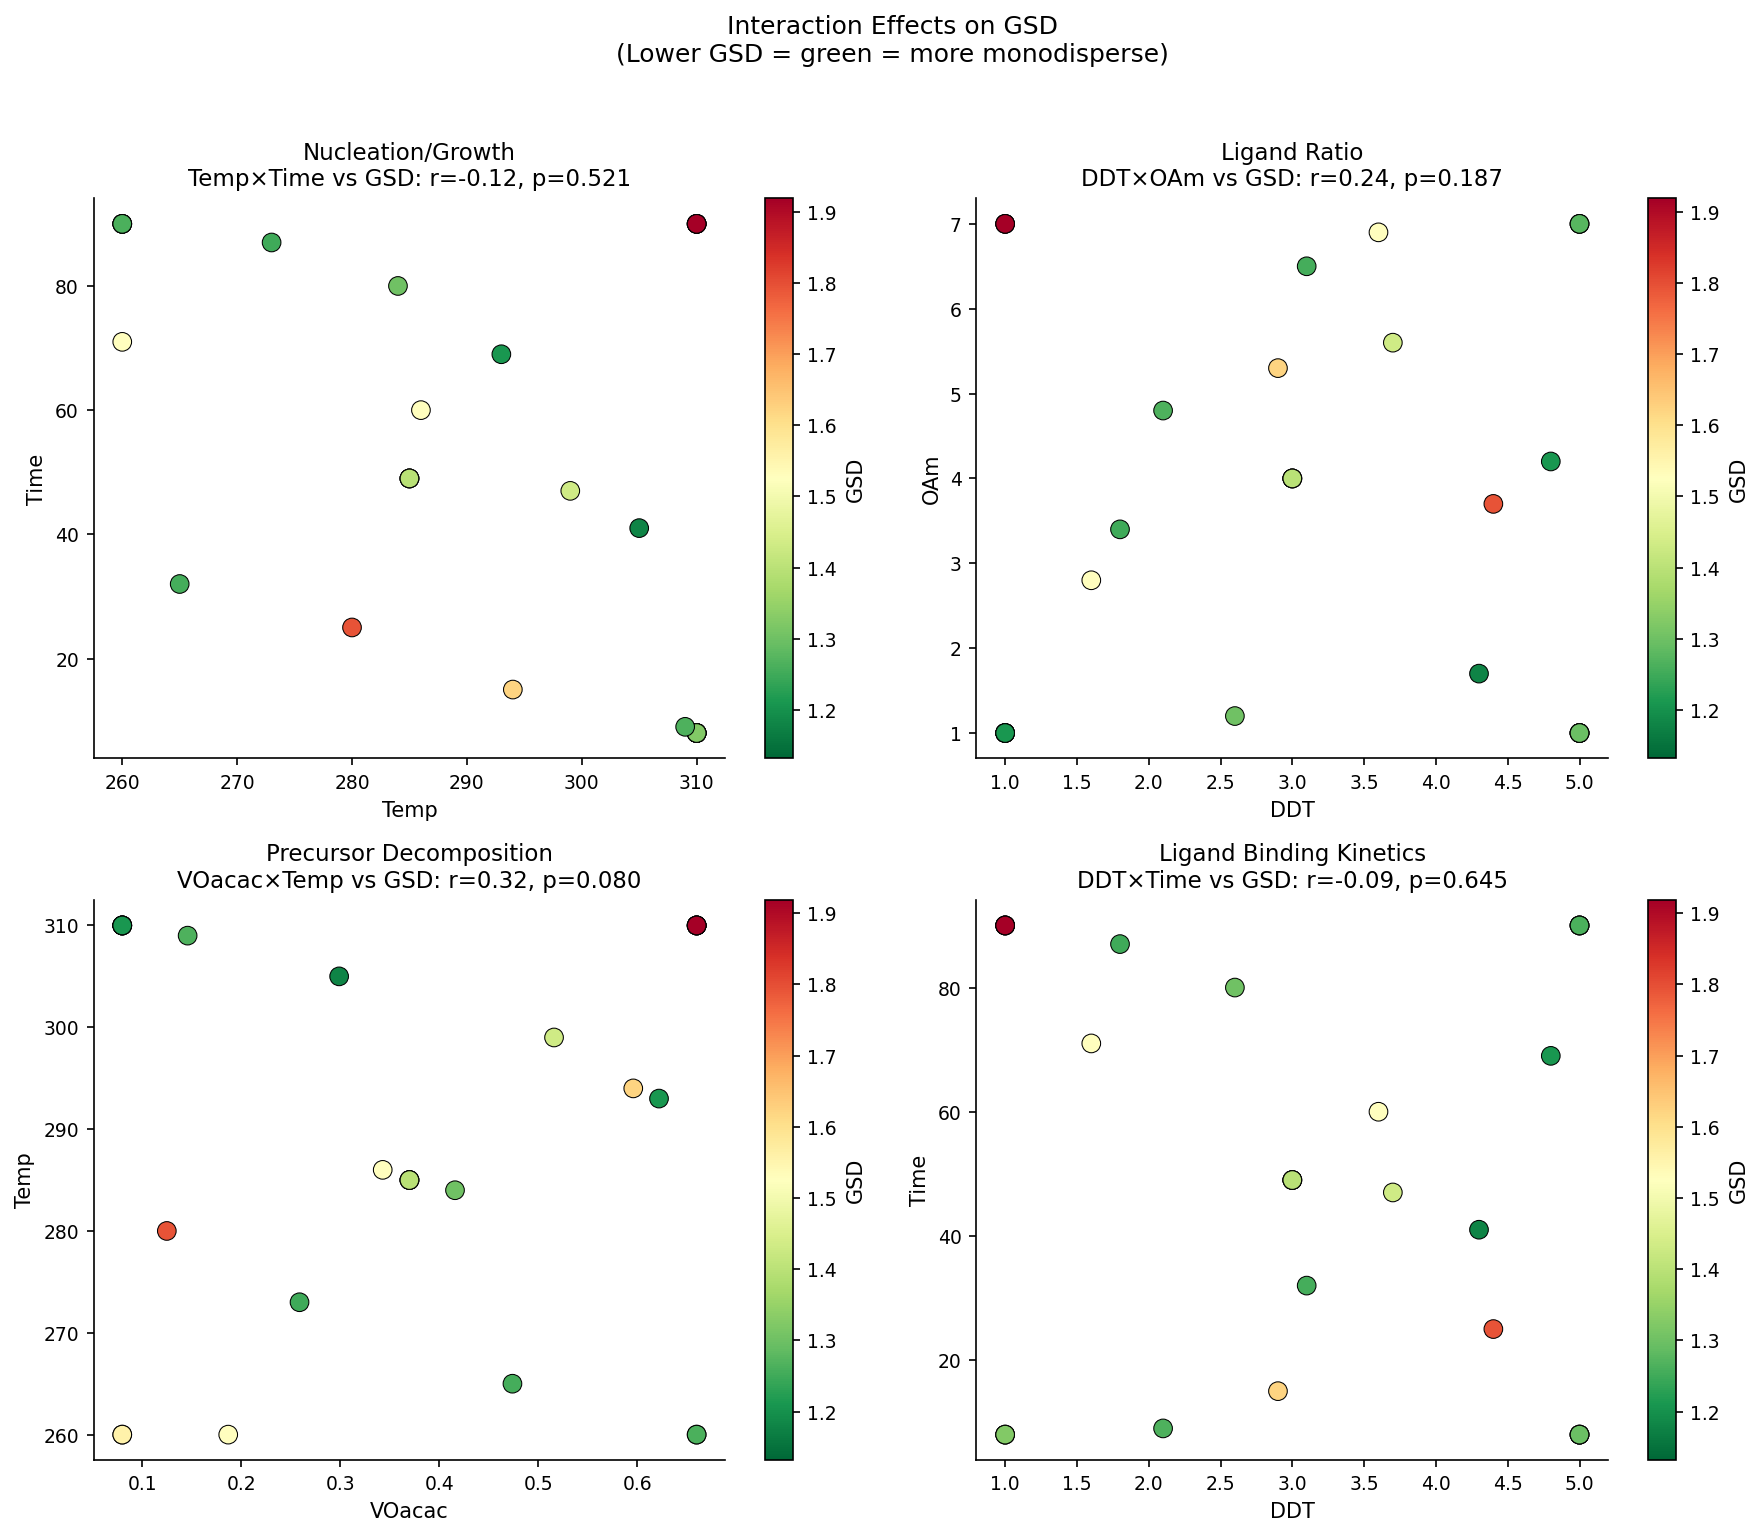



PART 2: ALTERNATIVE POLYDISPERSITY METRICS

Checking available columns...
['Temp', 'Time', 'VOacac', 'DDT', 'OAm', 'Run_ID', 'GSD', 'Squareness', 'Size', 'PhasePure', 'HasProduct', 'Polymorph', 'IsCubic']

Computing CV from GSD...
CV range: 0.124 - 0.727
CV mean:  0.316

----------------------------------------------------------------------
CORRELATION COMPARISON: GSD vs CV
----------------------------------------------------------------------

Factor         GSD corr      CV corr
----------------------------------------
Temp       -0.222     -0.222    
Time       +0.151     +0.151    
VOacac     -0.124     -0.124    
DDT        -0.126     -0.126    
OAm        -0.051     -0.051    

----------------------------------------------------------------------
SIZE-DEPENDENT POLYDISPERSITY
----------------------------------------------------------------------

Size vs GSD correlation: r = -0.352, p = 0.052
→ GSD depends on Size! Should use size-adjusted metric or model jointly.


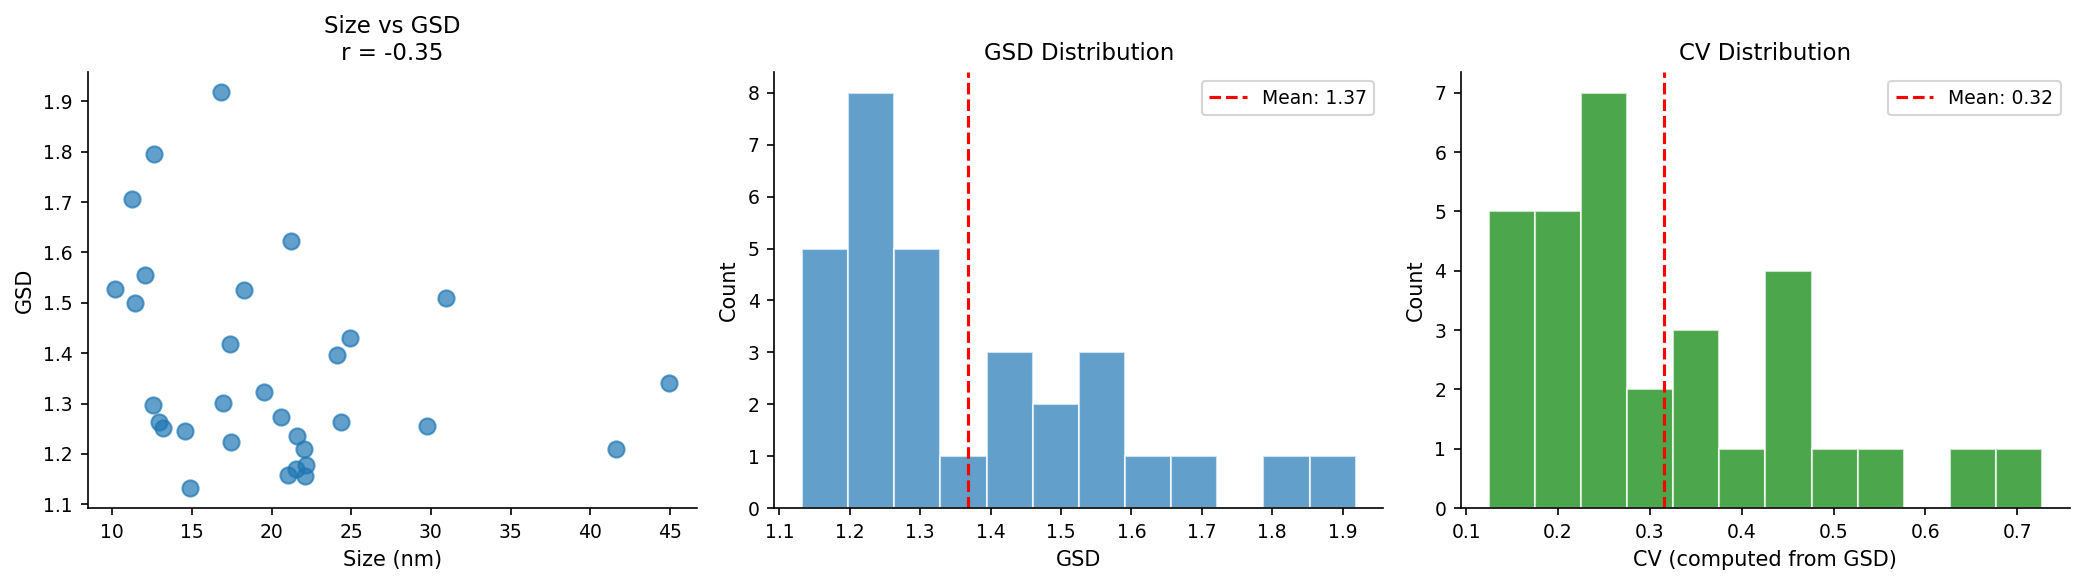



SUMMARY AND RECOMMENDATIONS

INTERACTION ANALYSIS RESULTS:
-----------------------------
Best model R² for GSD: -0.516



✗ INTERACTIONS DON'T HELP MUCH
  Even with interactions, R² < 0.10 suggests GSD is largely unpredictable
  from the factors you varied.

  RECOMMENDATION:
  - Report GSD as "largely independent of synthesis conditions"
  - Focus optimization on Size and Squareness
  - Consider other factors not in your DoE (injection rate, stirring, etc.)


ALTERNATIVE METRICS:
-------------------
CV (Coefficient of Variation) is mathematically equivalent to GSD for 
log-normal distributions. If your size distributions are NOT log-normal,
consider computing metrics directly from the raw distribution data:
- Span = (D90-D10)/D50 (robust to outliers)
- PDI = (σ/μ)² (standard in DLS literature)



In [ ]:
# =============================================================================
# ANALYSIS: Interactions and Alternative Polydispersity Metrics
# =============================================================================
# Two questions:
# 1. Does PDI depend on INTERACTIONS between factors?
# 2. Is there a better polydispersity metric that shows clearer relationships?
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

# Assuming df is loaded
df_success = df[df["HasProduct"] == 1].copy()

print("=" * 70)
print("PART 1: INTERACTION ANALYSIS FOR PDI")
print("=" * 70)

# =============================================================================
# CELL 1: Create interaction features
# =============================================================================
X = df_success[FACTOR_ORDER].values
y_PDI = df_success["PDI"].values

# Standardize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial features (interactions + quadratic)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X_scaled)
feature_names = poly.get_feature_names_out(FACTOR_ORDER)

print(f"\nOriginal features: {len(FACTOR_ORDER)}")
print(f"With interactions + quadratic: {X_poly.shape[1]}")
print(f"\nFeature names:")
for i, name in enumerate(feature_names):
    print(f"  {i+1:2d}. {name}")

# =============================================================================
# CELL 2: Test if interactions improve PDI prediction
# =============================================================================
print("\n" + "-" * 70)
print("TESTING INTERACTION MODELS FOR PDI")
print("-" * 70)

# Model 1: Linear (no interactions)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
scores_linear = cross_val_score(lr, X_scaled, y_PDI, cv=5, scoring='r2')
print(f"\nLinear (main effects only):     R² = {scores_linear.mean():.3f} ± {scores_linear.std():.3f}")

# Model 2: Linear with interactions
scores_poly = cross_val_score(lr, X_poly, y_PDI, cv=5, scoring='r2')
print(f"Linear + interactions:          R² = {scores_poly.mean():.3f} ± {scores_poly.std():.3f}")

# Model 3: Lasso with interactions (sparse selection)
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_poly, y_PDI)
scores_lasso = cross_val_score(lasso, X_poly, y_PDI, cv=5, scoring='r2')
print(f"Lasso + interactions:           R² = {scores_lasso.mean():.3f} ± {scores_lasso.std():.3f}")

# Model 4: Random Forest (captures all interactions automatically)
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
scores_rf = cross_val_score(rf, X_scaled, y_PDI, cv=5, scoring='r2')
print(f"Random Forest:                  R² = {scores_rf.mean():.3f} ± {scores_rf.std():.3f}")

# Model 5: Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
scores_gb = cross_val_score(gb, X_scaled, y_PDI, cv=5, scoring='r2')
print(f"Gradient Boosting:              R² = {scores_gb.mean():.3f} ± {scores_gb.std():.3f}")

# =============================================================================
# CELL 3: Which interactions matter most?
# =============================================================================
print("\n" + "-" * 70)
print("IMPORTANT INTERACTIONS (Lasso selection)")
print("-" * 70)

# Fit Lasso and look at non-zero coefficients
lasso_final = LassoCV(cv=5, random_state=42)
lasso_final.fit(X_poly, y_PDI)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_final.coef_
})
coef_df['Abs_Coef'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df[coef_df['Abs_Coef'] > 0.001].sort_values('Abs_Coef', ascending=False)

if len(coef_df) > 0:
    print("\nNon-zero coefficients (interactions that matter):")
    for _, row in coef_df.head(10).iterrows():
        print(f"  {row['Feature']:<20} coef = {row['Coefficient']:+.4f}")
else:
    print("\nNo significant coefficients found - PDI truly has no learnable signal")

# =============================================================================
# CELL 4: Visualize key interactions
# =============================================================================
print("\n" + "-" * 70)
print("INTERACTION VISUALIZATIONS")
print("-" * 70)

# Test specific interactions that make chemical sense
interactions_to_test = [
    ("Temp", "Time", "Nucleation/Growth"),
    ("DDT", "OAm", "Ligand Ratio"),
    ("VOacac", "Temp", "Precursor Decomposition"),
    ("DDT", "Time", "Ligand Binding Kinetics"),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (f1, f2, title) in zip(axes.flat, interactions_to_test):
    x1 = df_success[f1].values
    x2 = df_success[f2].values
    
    # Create interaction term
    x1_scaled = (x1 - x1.mean()) / x1.std()
    x2_scaled = (x2 - x2.mean()) / x2.std()
    interaction = x1_scaled * x2_scaled
    
    # Correlation with PDI
    r, p = spearmanr(interaction, y_PDI)
    
    # Scatter plot colored by PDI
    sc = ax.scatter(x1, x2, c=y_PDI, cmap='RdYlGn_r', s=80, edgecolor='black', linewidth=0.5)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title(f"{title}\n{f1}×{f2} vs PDI: r={r:.2f}, p={p:.3f}")
    plt.colorbar(sc, ax=ax, label='PDI')

plt.suptitle("Interaction Effects on PDI\n(Lower PDI = green = more monodisperse)", y=1.02)
plt.tight_layout()
plt.savefig("PDI_interactions.png", dpi=300, bbox_inches='tight')
plt.show()


# =============================================================================
# PART 2: ALTERNATIVE POLYDISPERSITY METRICS
# =============================================================================
print("\n\n" + "=" * 70)
print("PART 2: ALTERNATIVE POLYDISPERSITY METRICS")
print("=" * 70)

# Check if we have raw size distribution data or just summary statistics
print("\nChecking available columns...")
print(df_success.columns.tolist())

# If you have the raw particle sizes, we could compute:
# - CV = std/mean
# - Span = (D90-D10)/D50
# - PDI = (std/mean)²

# For now, let's work with what we have and compute CV from Size and PDI
# PDI is exp(ln_std), so: CV ≈ sqrt(exp(ln_std²) - 1) ≈ ln_std for small values

# Actually, let's compute CV directly if we have mean and std
# PDI = exp(σ_ln) where σ_ln is the std of ln(sizes)
# CV = sqrt(exp(σ_ln²) - 1)

print("\nComputing CV from PDI...")
# For log-normal: CV = sqrt(exp(ln(PDI)²) - 1)
PDI_vals = df_success["PDI"].values
cv_computed = np.sqrt(np.exp(np.log(PDI_vals)**2) - 1)

df_success["CV_computed"] = cv_computed

print(f"CV range: {cv_computed.min():.3f} - {cv_computed.max():.3f}")
print(f"CV mean:  {cv_computed.mean():.3f}")

# =============================================================================
# CELL 5: Compare correlations - PDI vs CV
# =============================================================================
print("\n" + "-" * 70)
print("CORRELATION COMPARISON: PDI vs CV")
print("-" * 70)

print(f"\n{'Factor':<10} {'PDI corr':>12} {'CV corr':>12}")
print("-" * 40)

for factor in FACTOR_ORDER:
    r_PDI, p_PDI = spearmanr(df_success[factor], df_success["PDI"])
    r_cv, p_cv = spearmanr(df_success[factor], df_success["CV_computed"])
    
    sig_PDI = "*" if p_PDI < 0.05 else " "
    sig_cv = "*" if p_cv < 0.05 else " "
    
    print(f"{factor:<10} {r_PDI:+.3f}{sig_PDI:>4} {r_cv:+.3f}{sig_cv:>4}")

# =============================================================================
# CELL 6: What about Size-normalized metrics?
# =============================================================================
print("\n" + "-" * 70)
print("SIZE-DEPENDENT POLYDISPERSITY")
print("-" * 70)

# Sometimes polydispersity depends on size - smaller particles are harder to make uniform
# Let's check: does PDI correlate with Size?

r_size_PDI, p_size_PDI = spearmanr(df_success["Size"], df_success["PDI"])
print(f"\nSize vs PDI correlation: r = {r_size_PDI:.3f}, p = {p_size_PDI:.3f}")

if p_size_PDI < 0.1:
    print("→ PDI depends on Size! Should use size-adjusted metric or model jointly.")
else:
    print("→ PDI is independent of Size (good - they can be optimized separately)")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# PDI vs Size
ax = axes[0]
ax.scatter(df_success["Size"], df_success["PDI"], s=60, alpha=0.7)
ax.set_xlabel("Size (nm)")
ax.set_ylabel("PDI")
ax.set_title(f"Size vs PDI\nr = {r_size_PDI:.2f}")

# PDI distribution
ax = axes[1]
ax.hist(df_success["PDI"], bins=12, edgecolor='white', alpha=0.7)
ax.axvline(df_success["PDI"].mean(), color='red', linestyle='--', label=f'Mean: {df_success["PDI"].mean():.2f}')
ax.set_xlabel("PDI")
ax.set_ylabel("Count")
ax.set_title("PDI Distribution")
ax.legend()

# CV distribution  
ax = axes[2]
ax.hist(cv_computed, bins=12, edgecolor='white', alpha=0.7, color='green')
ax.axvline(cv_computed.mean(), color='red', linestyle='--', label=f'Mean: {cv_computed.mean():.2f}')
ax.set_xlabel("CV (computed from PDI)")
ax.set_ylabel("Count")
ax.set_title("CV Distribution")
ax.legend()

plt.tight_layout()
plt.savefig("polydispersity_analysis.png", dpi=300, bbox_inches='tight')
plt.show()


# =============================================================================
# CELL 7: FINAL RECOMMENDATION
# =============================================================================
print("\n\n" + "=" * 70)
print("SUMMARY AND RECOMMENDATIONS")
print("=" * 70)

# Get best R² from interaction models
best_r2 = max(scores_linear.mean(), scores_poly.mean(), scores_lasso.mean(), 
              scores_rf.mean(), scores_gb.mean())

print(f"""
INTERACTION ANALYSIS RESULTS:
-----------------------------
Best model R² for PDI: {best_r2:.3f}

""")

if best_r2 > 0.25:
    print("""
✓ INTERACTIONS HELP!
  The best model achieves R² > 0.25, suggesting PDI has learnable structure
  when interactions are included.
  
  RECOMMENDATION: Use Random Forest or Gradient Boosting for PDI prediction,
  or include interaction terms in the GP.
""")
elif best_r2 > 0.10:
    print("""
⚠ MARGINAL IMPROVEMENT WITH INTERACTIONS
  R² between 0.1-0.25 suggests weak but potentially real effects.
  
  RECOMMENDATION: 
  - Use ensemble model (RF/GB) for PDI
  - Report predictions with high uncertainty
  - Consider this a secondary objective
""")
else:
    print("""
✗ INTERACTIONS DON'T HELP MUCH
  Even with interactions, R² < 0.10 suggests PDI is largely unpredictable
  from the factors you varied.
  
  RECOMMENDATION:
  - Report PDI as "largely independent of synthesis conditions"
  - Focus optimization on Size and Squareness
  - Consider other factors not in your DoE (injection rate, stirring, etc.)
""")

print("""
ALTERNATIVE METRICS:
-------------------
CV (Coefficient of Variation) is mathematically equivalent to PDI for 
log-normal distributions. If your size distributions are NOT log-normal,
consider computing metrics directly from the raw distribution data:
- Span = (D90-D10)/D50 (robust to outliers)
- PDI = (σ/μ)² (standard in DLS literature)
""")